# XJTU-SY Bearing Dataset (Work status 1) RUL prediction
**DATA PREPROCESS: The original amplitude data is stored in csv format and in columns, here the time serie amplitude data in each sample file is stored in rows, and all sample data rows for one bearing are vertically stacked and stored in .mat format**
- For other datasets, like **IMS dataset** from University of Cincinnati, or **CoE dataset** from NASA, or **real data** from labs. I have trained and tested using the same models I used in this notebook, and the results are also quite good. Here I will only take XJTU-SY bearing dataset as an example to show the whole process of RUL prediction.
- Anyway, **PLEASE REMEMBER!!!** The original column data for one smapling should be transformed into row data before feature extraction and model training.

In [1]:
import numpy as np  
import pywt  
import matplotlib.pyplot as plt  
import scipy.io
import pandas as pd

# Data Denoising

In [2]:
def wavelet_denoising(signal, wavelet='sym5', threshold=None):  
    coeffs = pywt.wavedec(signal, wavelet)  
    detail_coeffs = coeffs[1:]  

    # 动态确定阈值（例如使用标准差的某个倍数）  
    if threshold is None:  
        threshold = np.median(np.abs(detail_coeffs[0])) / 0.6745  # 计算基于MAD的动态阈值  

    for i in range(len(detail_coeffs)):  
        detail_coeffs[i] = pywt.threshold(detail_coeffs[i], threshold, mode='soft')  

    coeffs_denoised = [coeffs[0]] + detail_coeffs  
    denoised_signal = pywt.waverec(coeffs_denoised, wavelet)  
    
    return denoised_signal

In [3]:
def process_all_signals(original_data, wavelet='sym5', threshold=None):
    denoised_data = np.zeros_like(original_data)
    for i in range(original_data.shape[0]):
        denoised_data[i, :] = wavelet_denoising(original_data[i, :], wavelet, threshold)
    return denoised_data

# Import data for data denosing and feature extraction visualization

In [4]:
T_data1 = scipy.io.loadmat('D:\数据集XJTU\西交大1-1水平.mat')['a']
print(T_data1.shape)
T_data1 = T_data1[:, -2560:]
# 调用去噪处理，尝试不同的小波基和阈值  
denoised_data = process_all_signals(T_data1, wavelet='db4')  

(123, 32768)


In [5]:
from matplotlib import rcParams  

# 设置字体  
rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体  
rcParams['axes.unicode_minus'] = False  # 处理负号的显示

# Calculate statistical features from original amplitude data

Signal 1: {'peak_to_peak': 3.014793936004097, 'mean': 0.0009699414446148122, 'std_dev': 0.2200785095515863, 'rms': 0.22008064692937826, 'pulse_factor': 7.225778892369788, 'peak_factor': 7.225778892369788, 'energy': 123.99485735130534, 'skewness': 0.053569457083045786, 'kurtosis': 3.5377853563132042, 'upper_bound': 0.44112696054778744, 'arctan_std_dev': 0.2166251888544159}
Signal 2: {'peak_to_peak': 1.2431382232555306, 'mean': -0.010330992016381314, 'std_dev': 0.1512116856517878, 'rms': 0.15156418862547189, 'pulse_factor': 4.221626437464337, 'peak_factor': 4.221626437464337, 'energy': 58.807560380665905, 'skewness': 0.3164963964178918, 'kurtosis': 1.5452574446988985, 'upper_bound': 0.2920923792871943, 'arctan_std_dev': 0.15007475909306423}
Signal 3: {'peak_to_peak': 4.666790665502111, 'mean': -0.005810785879495766, 'std_dev': 0.41463662599746587, 'rms': 0.414677340653067, 'pulse_factor': 7.066600822355864, 'peak_factor': 7.066600822355864, 'energy': 440.21067993881536, 'skewness': 0.146

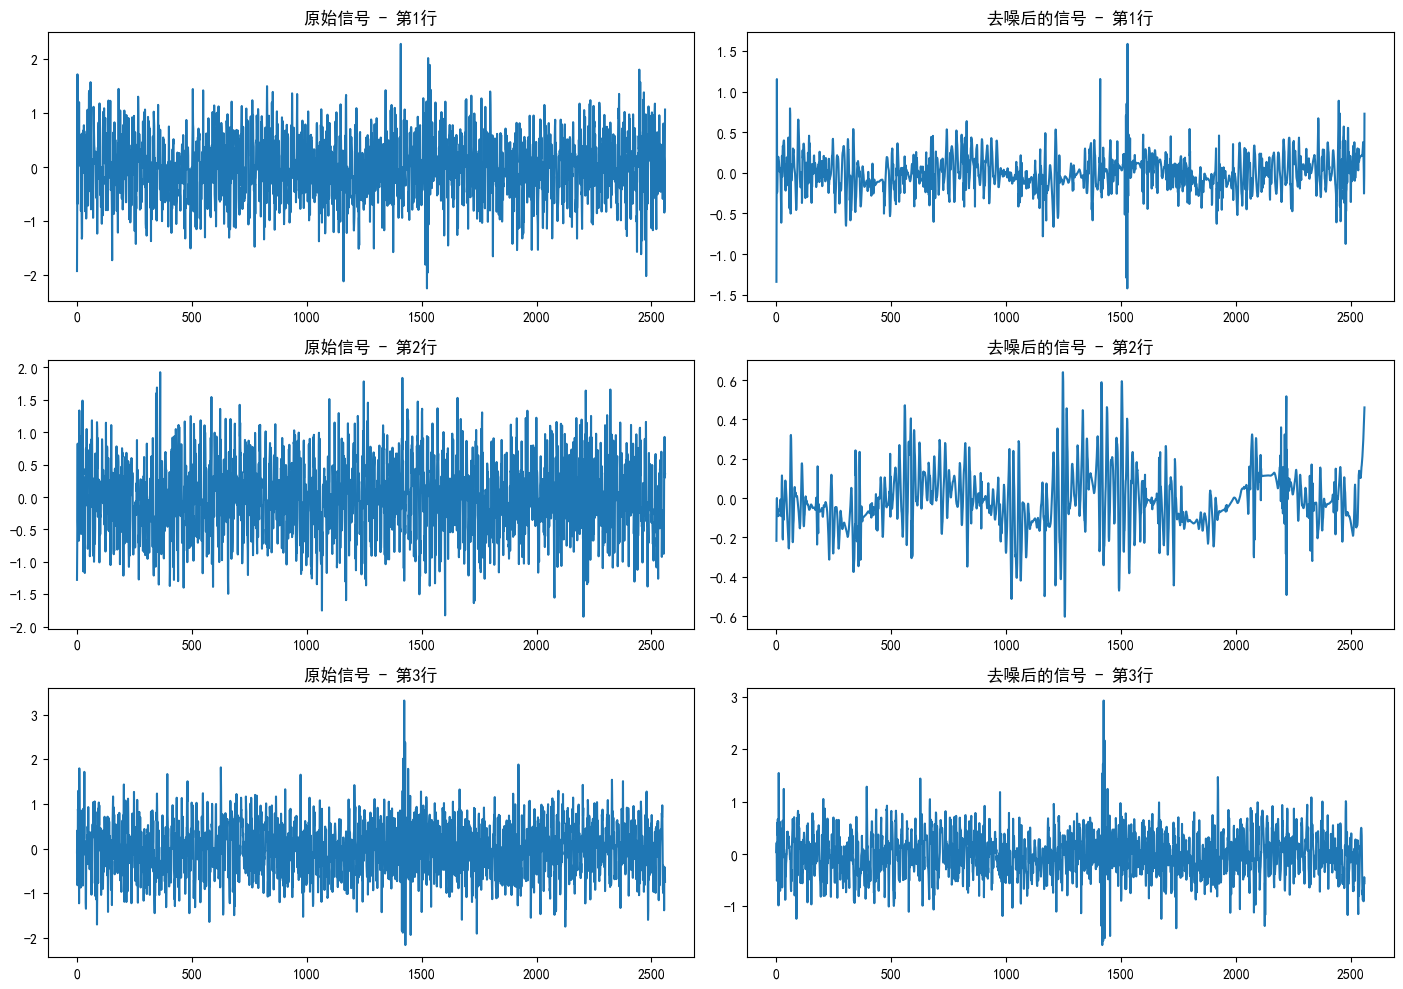

In [6]:
from scipy.stats import kurtosis, skew  

def calculate_statistics(signals):  
    statistics_list = []  
    
    for signal in signals:  
        peak_to_peak = np.max(signal) - np.min(signal)  
        mean = np.mean(signal)  
        std_dev = np.std(signal)  
        rms = np.sqrt(np.mean(signal**2))  
        positive_peak = np.max(signal)  
        negative_peak = np.min(signal)  
        # crest_factor = positive_peak / rms if rms != 0 else 0  
        peak_factor = positive_peak / rms if rms != 0 else 0  
        
        # 计算能量  
        energy = np.sum(signal**2)  
        
        # 计算偏度和峭度  
        skewness = skew(signal)  
        kurt = kurtosis(signal)  

        # 计算上边界  
        upper_bound = mean + 2 * std_dev  # 取均值加上2倍标准差为上边界  

        # 计算反正切值标准差  
        arctan_std_dev = np.arctan(std_dev)  
        
        pulse_factor = positive_peak / rms  
        # 将所有特征存入字典  
        statistics_list.append({  
            'peak_to_peak': peak_to_peak,  
            'mean': mean,  
            'std_dev': std_dev,  
            'rms': rms,  
            'pulse_factor': pulse_factor,  
            'peak_factor': peak_factor,  
            'energy': energy,  
            'skewness': skewness,  
            'kurtosis': kurt,  
            'upper_bound': upper_bound,  
            'arctan_std_dev': arctan_std_dev  
        })  

    return statistics_list  

# 示例信号（请用实际的去噪信号替换此信号）    # 使用去噪后的重构信号，形状应为 (N, 2560)  

# 计算统计特征  
statistics_results = calculate_statistics(denoised_data)  

# 输出结果  
for i, stats in enumerate(statistics_results):  
    print(f"Signal {i+1}: {stats}")


# 可视化原始信号与去噪信号  
plt.figure(figsize=(14, 10))  
for i in range(3):  # 可视化前3个信号  
    plt.subplot(3, 2, 2*i + 1)  
    plt.plot(T_data1[i, :])  
    plt.title(f'原始信号 - 第{i+1}行')  
    
    plt.subplot(3, 2, 2*i + 2)  
    plt.plot(denoised_data[i, :])  
    plt.title(f'去噪后的信号 - 第{i+1}行')  
    
plt.tight_layout()  
plt.show()  

# Visualize SOME statistical feature changes

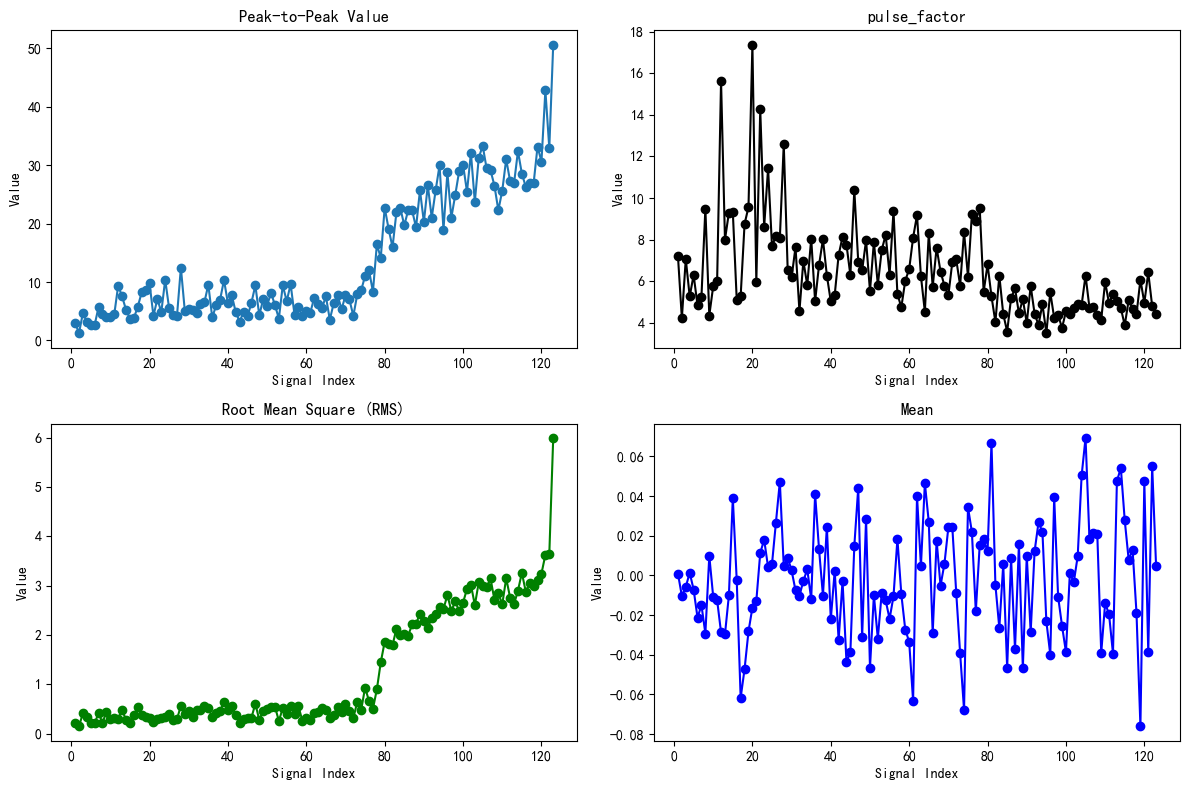

In [7]:
def plot_statistics(statistics_results):  
    num_signals = len(statistics_results)  
    
    # 统计特征  
    peak_to_peak = [stats['peak_to_peak'] for stats in statistics_results]  
    std_dev = [stats['std_dev'] for stats in statistics_results]  
    rms = [stats['rms'] for stats in statistics_results]  
    # triangle_feature = [stats['triangle_feature'] for stats in statistics_results]  
    mean = [stats['mean'] for stats in statistics_results]
    # wiener_entropy = [stats['wiener_entropy'] for stats in statistics_results]
    pulse_factor = [stats['pulse_factor'] for stats in statistics_results]
    # 创建图形  
    plt.figure(figsize=(12, 8))  

    # 峰峰值  
    plt.subplot(2, 2, 1)  
    plt.plot(range(1, num_signals + 1), peak_to_peak, marker='o')  
    plt.title('Peak-to-Peak Value')  
    plt.xlabel('Signal Index')  
    plt.ylabel('Value')  
    
    # # 标准差  
    # plt.subplot(2, 2, 2)  
    # plt.plot(range(1, num_signals + 1), std_dev, marker='o', color='orange')  
    # plt.title('Standard Deviation')  
    # plt.xlabel('Signal Index')  
    # plt.ylabel('Value')  
    
    # 均方根  
    plt.subplot(2, 2, 3)  
    plt.plot(range(1, num_signals + 1), rms, marker='o', color='green')  
    plt.title('Root Mean Square (RMS)')  
    plt.xlabel('Signal Index')  
    plt.ylabel('Value')  
    
    # # 三角特征  
    # plt.subplot(2, 2, 4)  
    # plt.plot(range(1, num_signals + 1), triangle_feature, marker='o', color='red')  
    # plt.title('Triangle Feature')  
    # plt.xlabel('Signal Index')  
    # plt.ylabel('Value')  
    # 
    # 均值
    plt.subplot(2, 2, 4)
    plt.plot(range(1, num_signals + 1), mean, marker='o', color='blue')
    plt.title('Mean')
    plt.xlabel('Signal Index')
    plt.ylabel('Value')
    
    # # 维纳熵
    # plt.subplot(2, 2, 4)
    # plt.plot(range(1, num_signals + 1), wiener_entropy, marker='o', color='purple')
    # plt.title('Wiener Entropy')
    # plt.xlabel('Signal Index')
    # plt.ylabel('Value')
    
   
    plt.subplot(2, 2, 2)
    plt.plot(range(1, num_signals + 1),pulse_factor, marker='o', color='black')
    plt.title('pulse_factor')
    plt.xlabel('Signal Index')
    plt.ylabel('Value')
    
    plt.tight_layout()  
    plt.show()  
# 可视化统计特征变化  
plot_statistics(statistics_results)

# Smoothing statistical features

[[ 3.01479394e+00  9.69941445e-04  2.20078510e-01 ...  3.53778536e+00
   4.41126961e-01  2.16625189e-01]
 [ 1.24313822e+00 -1.03309920e-02  1.51211686e-01 ...  1.54525744e+00
   2.92092379e-01  1.50074759e-01]
 [ 4.66679067e+00 -5.81078588e-03  4.14636626e-01 ...  1.58373483e+00
   8.23462466e-01  3.93060135e-01]
 ...
 [ 4.28017385e+01 -3.85541440e-02  3.62892168e+00 ...  2.79421565e+00
   7.21928922e+00  1.30190589e+00]
 [ 3.29162972e+01  5.51341305e-02  3.63963490e+00 ...  2.09285783e+00
   7.33440393e+00  1.30265992e+00]
 [ 5.06165588e+01  4.57633387e-03  5.99747887e+00 ...  1.79968958e+00
   1.19995341e+01  1.40557948e+00]]
smoothed_basic (123, 11)
smoothed_result [{'peak_to_peak': 2.862267628401429, 'mean': 0.6110751718553247, 'std_dev': -0.6950793360644787, 'rms': 2.0403260948403648, 'pulse_factor': -4.58446434116269, 'peak_factor': 48.47614073663861, 'energy': 61.799258926273616, 'skewness': 43.09433359151664, 'kurtosis': -8.75873541575956, 'upper_bound': 8.63880747526278, 'arct

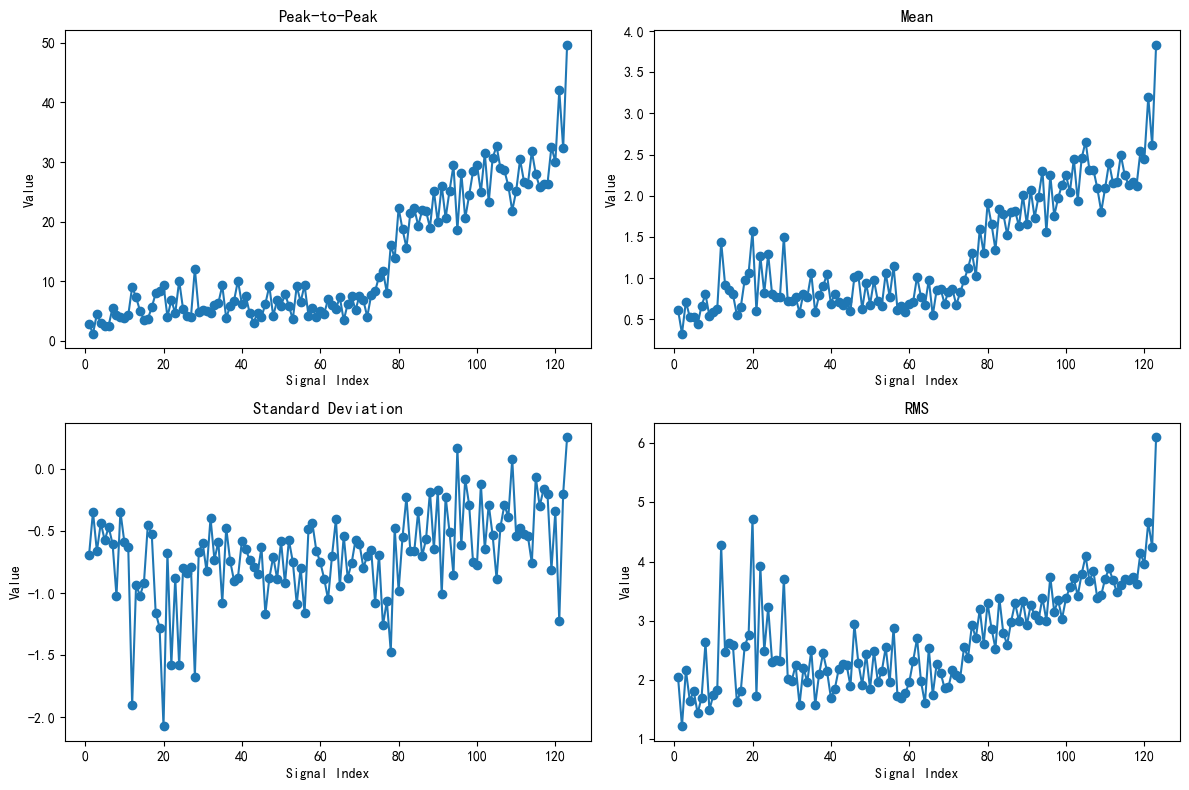

num_signals 123


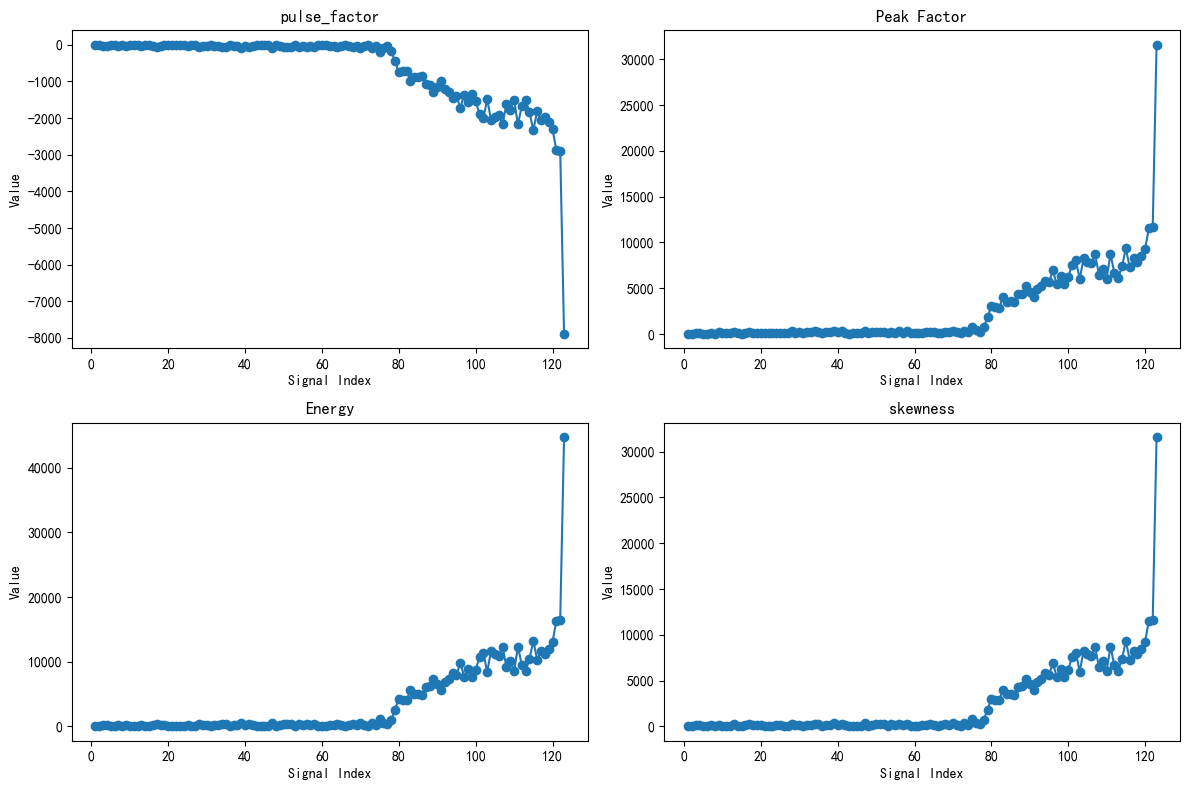

num_signals 123


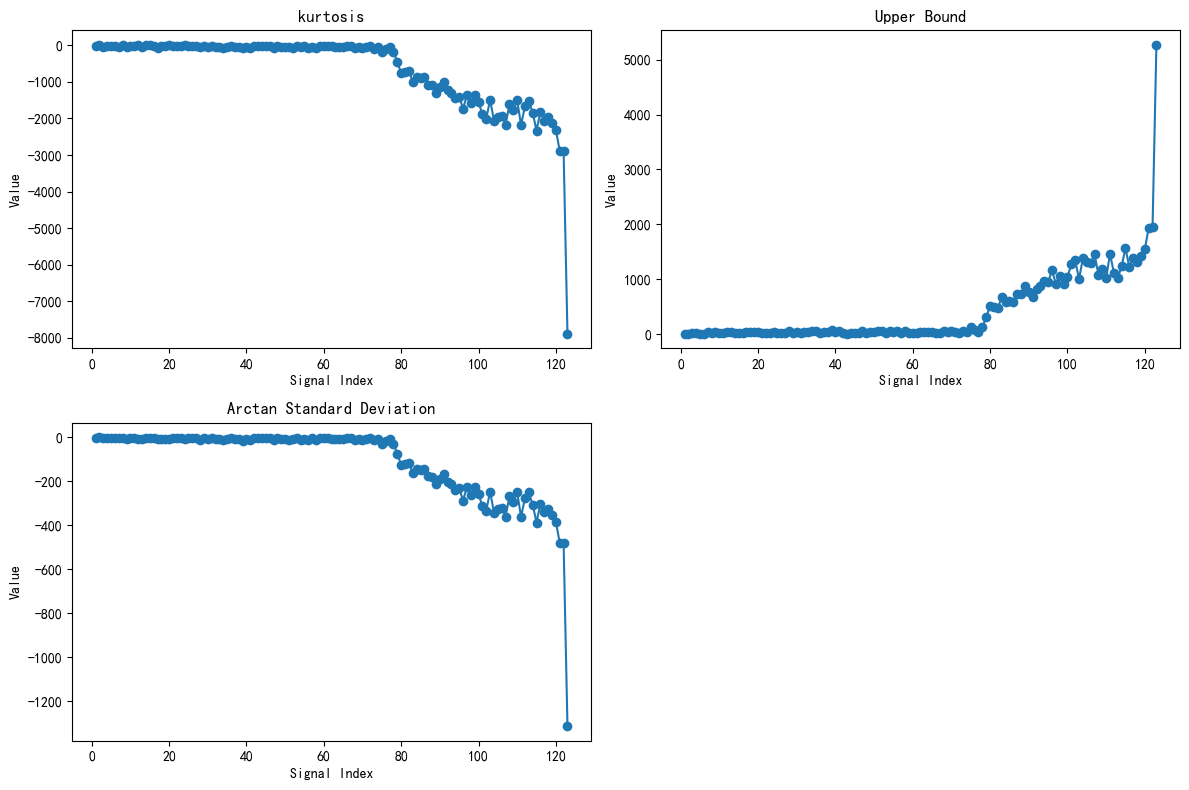

Signal 1 Statistics: {'peak_to_peak': 3.014793936004097, 'mean': 0.0009699414446148122, 'std_dev': 0.2200785095515863, 'rms': 0.22008064692937826, 'pulse_factor': 7.225778892369788, 'peak_factor': 7.225778892369788, 'energy': 123.99485735130534, 'skewness': 0.053569457083045786, 'kurtosis': 3.5377853563132042, 'upper_bound': 0.44112696054778744, 'arctan_std_dev': 0.2166251888544159}
Signal 2 Statistics: {'peak_to_peak': 1.2431382232555306, 'mean': -0.010330992016381314, 'std_dev': 0.1512116856517878, 'rms': 0.15156418862547189, 'pulse_factor': 4.221626437464337, 'peak_factor': 4.221626437464337, 'energy': 58.807560380665905, 'skewness': 0.3164963964178918, 'kurtosis': 1.5452574446988985, 'upper_bound': 0.2920923792871943, 'arctan_std_dev': 0.15007475909306423}
Signal 3 Statistics: {'peak_to_peak': 4.666790665502111, 'mean': -0.005810785879495766, 'std_dev': 0.41463662599746587, 'rms': 0.414677340653067, 'pulse_factor': 7.066600822355864, 'peak_factor': 7.066600822355864, 'energy': 440.

In [8]:
from scipy.signal import savgol_filter  
def smooth_statistics(statistics, window_size=5, poly_order=3):  
    features = np.array([[  
        stats['peak_to_peak'],   
        stats['mean'],   
        stats['std_dev'],   
        stats['rms'],   
        stats['pulse_factor'],   
        stats['peak_factor'],  
        stats['energy'],  
        stats['skewness'],   
        stats['kurtosis'],   
        stats['upper_bound'],  
        stats['arctan_std_dev']  
    ] for stats in statistics])  
    print(features)
    smoothed_result_list=[]
    smoothed_statistics = []  
    
    for feature in features:
        smoothed_result={}
        smoothed_feature = savgol_filter(feature, window_length=window_size, polyorder=poly_order,axis=0)
        smoothed_statistics.append(smoothed_feature)
        smoothed_result['peak_to_peak'] = smoothed_feature[0]
        smoothed_result['mean'] = smoothed_feature[1]
        smoothed_result['std_dev'] = smoothed_feature[2]
        smoothed_result['rms'] = smoothed_feature[3]
        smoothed_result['pulse_factor'] = smoothed_feature[4]
        smoothed_result['peak_factor'] = smoothed_feature[5]
        smoothed_result['energy'] = smoothed_feature[6]
        smoothed_result['skewness'] = smoothed_feature[7]
        smoothed_result['kurtosis'] = smoothed_feature[8]
        smoothed_result['upper_bound'] = smoothed_feature[9]
        smoothed_result['arctan_std_dev'] = smoothed_feature[10]
        smoothed_result_list.append(smoothed_result)
    return np.array(smoothed_statistics),smoothed_result_list # 转置为 (N, num_features)  

def plot_smoothed_statistics(smoothed_results, feature_names):  
    num_signals = smoothed_results.shape[0]
    print('num_signals',num_signals)
    
    plt.figure(figsize=(12, 8))  

    for i, feature_name in enumerate(feature_names):  
        plt.subplot(2, 2, i + 1)  
        plt.plot(range(1, num_signals + 1), smoothed_results[:, i], marker='o')  
        plt.title(feature_name)  
        plt.xlabel('Signal Index')  
        plt.ylabel('Value')  
    
    plt.tight_layout()  
    plt.show()  



# 提取特征  
basic_features = np.vstack([  
    [stats['peak_to_peak'],stats['mean'],stats['std_dev'],stats['rms'],stats['kurtosis'],stats['skewness'],stats['pulse_factor'],stats['peak_factor'],stats['energy'],stats['upper_bound'],stats['arctan_std_dev']]  
    for stats in statistics_results  
])  


# 对统计特征进行平滑处理  
smoothed_basic,smoothed_result = smooth_statistics(statistics_results)  
print('smoothed_basic',smoothed_basic.shape)
print('smoothed_result',smoothed_result)

# 可视化平滑后的统计特征  
plot_smoothed_statistics(smoothed_basic[:,0:4], ['Peak-to-Peak', 'Mean', 'Standard Deviation', 'RMS']) 
plot_smoothed_statistics(smoothed_basic[:,4:8], ['pulse_factor', 'Peak Factor','Energy','skewness'])
plot_smoothed_statistics(smoothed_basic[:,8:11], ['kurtosis','Upper Bound', 'Arctan Standard Deviation'])


# 输出结果  
for i, stats in enumerate(statistics_results):  
    print(f"Signal {i+1} Statistics: {stats}")  

# APPLY Cumulative transformation to SMOOTHED STATISTICAL FEATURES

In [9]:
def cumulative_transform(statistics):  
    features = np.array([[  
        stats['peak_to_peak'],   
        stats['mean'],   
        stats['std_dev'],   
        stats['rms'],   
        stats['pulse_factor'],   
        stats['peak_factor'],  
        stats['energy'],  
        stats['skewness'],   
        stats['kurtosis'],   
        stats['upper_bound'],  
        stats['arctan_std_dev']  
    ] for stats in statistics])  
    cumulative_features = []
    for feature in features:
        print('feature',feature)
        cumulative_feature = np.cumsum(feature)
        print('cumulative_feature',cumulative_feature)
        cumulative_features.append(cumulative_feature)
    cumulative_features = np.array(cumulative_features)
    return cumulative_features  

def plot_cumulative_results(cumulative_results):  
    num_features = cumulative_results.shape[1]  
    x = np.arange(1, cumulative_results.shape[0] + 1)  

    plt.figure(figsize=(12, 8))  

    # 为每个特征绘制图形  
    feature_names = ['Peak-to-Peak', 'Mean', 'Standard Deviation', 'RMS',   
                        'Pulse Factor', 'Peak Factor', 'Energy',
                        'Skewness', 'Kurtosis', 'Upper Bound',
                        'Arctan Standard Deviation']

    for i in range(num_features):  
        plt.subplot(4, 3, i + 1)  # 3x3 网格布局  
        plt.plot(x, cumulative_results[:, i])  
        plt.title(feature_names[i])  
        plt.xlabel('Signal Index')  
        plt.ylabel('Cumulative Value')  
        plt.grid()  

    plt.tight_layout()  
    plt.show()  

# 进行累积变换  
cumulative_results = cumulative_transform(smoothed_result)  
# energy=cumulative_results[:,6]
# 输出累积结果  
for i, cum_stats in enumerate(cumulative_results):  
    print(f"Cumulative Features for Signal {i+1}: {cum_stats}")

feature [ 2.86226763  0.61107517 -0.69507934  2.04032609 -4.58446434 48.47614074
 61.79925893 43.09433359 -8.75873542  8.63880748 -1.83279494]
cumulative_feature [  2.86226763   3.4733428    2.77826346   4.81858956   0.23412522
  48.71026595 110.50952488 153.60385847 144.84512306 153.48393053
 151.65113559]
feature [ 1.16017962  0.32150341 -0.34653991  1.2119075  -1.50372512 23.6203917
 29.62529568 20.45923132 -4.09429896  4.05179665 -0.78985131]
cumulative_feature [ 1.16017962  1.48168303  1.13514312  2.34705061  0.84332549 24.46371719
 54.08901287 74.54824419 70.45394523 74.50574188 73.71589057]
feature [  4.48699431   0.71337464  -0.66414152   2.16119983 -31.77052565
 156.73642557 215.54835389 150.86742396 -36.66410155  26.32202005
  -5.98157926]
cumulative_feature [  4.48699431   5.20036895   4.53622743   6.69742726 -25.07309839
 131.66332719 347.21168108 498.07910503 461.41500348 487.73702353
 481.75544427]
feature [  3.03445025   0.52270343  -0.4351753    1.64234483 -21.93043488


# Visualize cumulative results

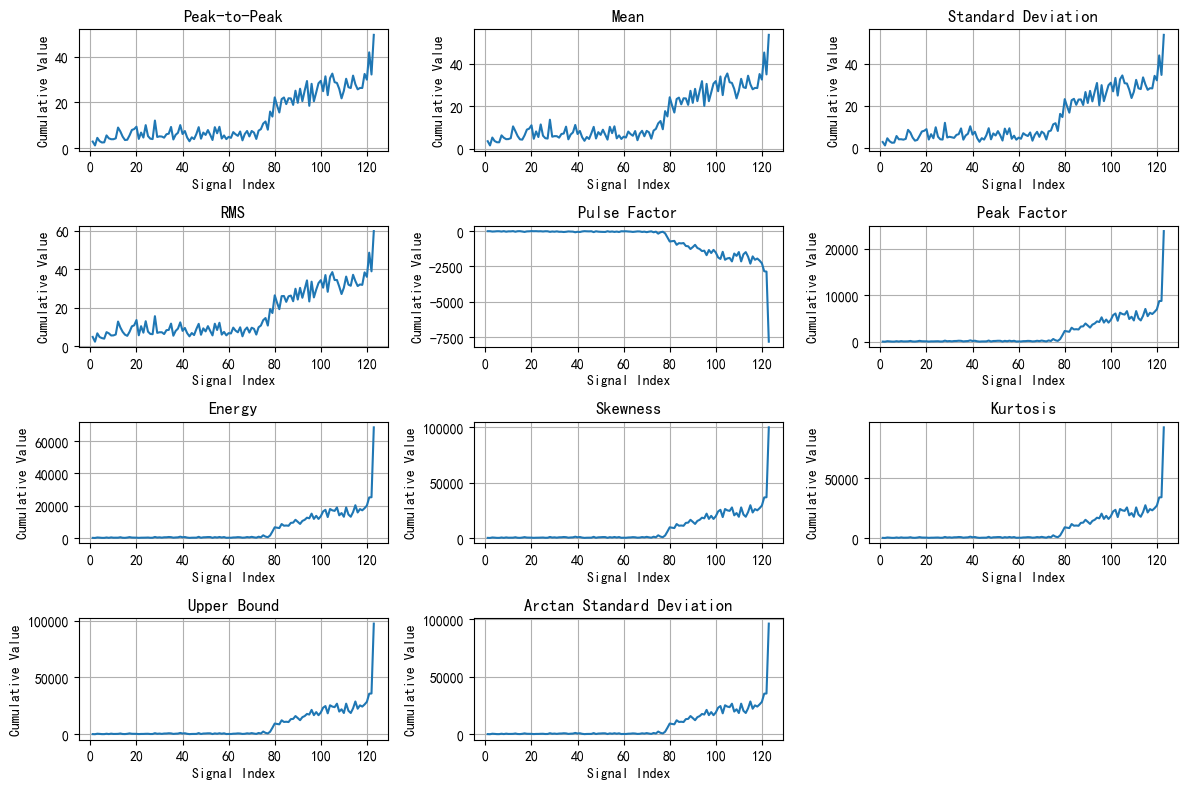

In [10]:
# 可视化累积结果
plot_cumulative_results(cumulative_results)

# The trends of the cumulative features are easy to observe now

# Select features based on monotonicity and trends

In [11]:
from sklearn.linear_model import LinearRegression  
def calculate_monotonicity_and_trend(cumulative_results):  
    monotonicity_values = []  
    trend_values = []  

    for feature in cumulative_results.T:  # 遍历每个特征  
        # 计算单调性  
        diff = np.diff(feature)  
        is_monotonic = np.all(diff >= 0)  # 非递减  
        monotonicity_values.append(1 if is_monotonic else 0)  # 可以根据需要设定评分标准  

        # 计算趋势性  
        x = np.arange(len(feature)).reshape(-1, 1)  
        model = LinearRegression()  
        model.fit(x, feature)  
        trend_values.append(model.coef_[0])  # 获取斜率  

    return monotonicity_values, trend_values  

def select_features(cumulative_results, monotonicity, trend, num_features=12):  
    # 组合单调性和趋势性为一个得分  
    scores = np.array(monotonicity) + np.array(trend) / np.max(np.abs(trend))  # 正规化趋势值
    print('score of :',scores)
    selected_indices = list(np.argsort(scores)[-num_features:])# 选择分数最高的特征

    return scores,selected_indices
# 计算单调性和趋势性  
# cumulative_results= (cumulative_results - np.min(cumulative_results, axis=0)) / (np.max(cumulative_results, axis=0) - np.min(cumulative_results, axis=0))
monotonicity_values, trend_values = calculate_monotonicity_and_trend(cumulative_results)  

# 筛选特征  
scores,selected_feature_indices = select_features(cumulative_results, monotonicity_values, trend_values, num_features=7)
print('selected_feature_indices',selected_feature_indices)
# 输出选择的特征  
# 输出选择的特征名称  
feature_names = ['Peak-to-Peak', 'Mean', 'Standard Deviation', 'RMS',   
                 'Pulse Factor', 'Peak Factor', 'Energy',   
                 'Skewness', 'Kurtosis', 'Upper Bound',   
                 'Arctan Standard Deviation']  
selected_features = cumulative_results[:, selected_feature_indices]
print(cumulative_results[0,[0,1]])
print(selected_features[0])
print("Selected Features Indices:", selected_feature_indices) 
print("Selected Features:", selected_features.shape)  
selected_feature_names = [feature_names[i] for i in selected_feature_indices]  
print("Selected Feature Names:", selected_feature_names)

score of : [ 9.25674317e-04  9.85232943e-04  1.00103755e-03  1.05855008e-03
 -7.78969624e-02  2.37556616e-01  6.84594722e-01  1.00000000e+00
  9.20982751e-01  9.73604731e-01  9.60538376e-01]
selected_feature_indices [3, 5, 6, 8, 10, 9, 7]
[2.86226763 3.4733428 ]
[  4.81858956  48.71026595 110.50952488 144.84512306 151.65113559
 153.48393053 153.60385847]
Selected Features Indices: [3, 5, 6, 8, 10, 9, 7]
Selected Features: (123, 7)
Selected Feature Names: ['RMS', 'Peak Factor', 'Energy', 'Kurtosis', 'Arctan Standard Deviation', 'Upper Bound', 'Skewness']


# Encapsulate data processing functions to a single extraction function

# Apply FEATURE FUSION to selected features with the highest evalution scores

# Min-Max normalization to the fused features and generate RUL labels that can accurately reflect the degradation trend of the bearing,
# THE RUL label will range from 1 to 0

In [12]:
#封装数据处理函数
def feature_extraction(data):
    denoised_data = process_all_signals(data, wavelet='db4')  
    statistics_results = calculate_statistics(denoised_data)
    
    
    basic_features = np.vstack([  
        [stats['peak_to_peak'], stats['std_dev'], stats['rms'], stats['kurtosis'], stats['skewness'], stats['pulse_factor'],stats['mean'],stats['upper_bound'],stats['arctan_std_dev'],stats['energy']]  
        for stats in statistics_results  
    ])  
    smoothed_basic,smoothed_result = smooth_statistics(statistics_results)  
    cumulative_results = cumulative_transform(smoothed_result)
    mean = np.mean(np.array([stats[7] for stats in cumulative_results]))
    print('mean',mean)
    std_dev = np.std(np.abs(np.array([stats[7] for stats in cumulative_results])))
    print('std_dev',std_dev)
    
    mean_1_std_dev = mean+0.5*std_dev
    print('mean_1_std_dev',mean_1_std_dev)
    # cumulative_results_sd = (cumulative_results - np.min(cumulative_results, axis=0)) / (np.max(cumulative_results, axis=0) - np.min(cumulative_results, axis=0))
    monotonicity_values, trend_values = calculate_monotonicity_and_trend(cumulative_results)  
    scores,selected_feature_indices = select_features(cumulative_results, monotonicity_values, trend_values, num_features=8)
    
   
    feature_names = ['Peak-to-Peak', 'Mean', 'Standard Deviation', 'RMS',   
                 'Pulse Factor', 'Peak Factor', 'Energy',   
                 'Skewness', 'Kurtosis', 'Upper Bound',   
                 'Arctan Standard Deviation']
    label=np.zeros((data.shape[0]))
    scores_i = scores
        
    # 找出大于 0.6 的项
    mask = scores_i> 0.9
    # if mask is all false,then set the one with the highest score to true
    if not mask.any():
        mask[np.argmax(scores_i)] = True
    selected_features = cumulative_results[:, selected_feature_indices]
    for i, cum_stats in enumerate(cumulative_results):
        label[i] = np.sum(cumulative_results[i][mask])
    print(selected_features[0])
    print("Selected Features Indices:", selected_feature_indices) 
    selected_feature_names = [feature_names[i] for i in selected_feature_indices]  
    print("Selected Feature Names:", selected_feature_names)
    print("Selected Features: ",selected_features.shape)
    # label = np.ones((data.shape[0]))
    return selected_features,label,mean_1_std_dev

In [13]:
T_data1 = scipy.io.loadmat('D:\数据集XJTU\西交大1-1水平.mat')['a']
T_data1 = T_data1[:, -2560:]
T_data1,label1,mean_1_std= feature_extraction(T_data1)

[[ 3.01479394e+00  9.69941445e-04  2.20078510e-01 ...  3.53778536e+00
   4.41126961e-01  2.16625189e-01]
 [ 1.24313822e+00 -1.03309920e-02  1.51211686e-01 ...  1.54525744e+00
   2.92092379e-01  1.50074759e-01]
 [ 4.66679067e+00 -5.81078588e-03  4.14636626e-01 ...  1.58373483e+00
   8.23462466e-01  3.93060135e-01]
 ...
 [ 4.28017385e+01 -3.85541440e-02  3.62892168e+00 ...  2.79421565e+00
   7.21928922e+00  1.30190589e+00]
 [ 3.29162972e+01  5.51341305e-02  3.63963490e+00 ...  2.09285783e+00
   7.33440393e+00  1.30265992e+00]
 [ 5.06165588e+01  4.57633387e-03  5.99747887e+00 ...  1.79968958e+00
   1.19995341e+01  1.40557948e+00]]
feature [ 2.86226763  0.61107517 -0.69507934  2.04032609 -4.58446434 48.47614074
 61.79925893 43.09433359 -8.75873542  8.63880748 -1.83279494]
cumulative_feature [  2.86226763   3.4733428    2.77826346   4.81858956   0.23412522
  48.71026595 110.50952488 153.60385847 144.84512306 153.48393053
 151.65113559]
feature [ 1.16017962  0.32150341 -0.34653991  1.2119075

In [14]:
def generate_label(label):
    # 先进行 min-max 归一化  
    label_normalized =1- (label - np.min(label)) / (np.max(label) - np.min(label))  

    # 找到除最后一个元素以外的 0 值元素的索引
    # print(min(skewness_normalized))
    zero_indices = np.where(label_normalized[:-1] == 0)
    # print('zero_indices',zero_indices)
    # 计算除最后一个元素以外非 0 元素的平均值  
    non_zero_values = label[:-1][label[:-1] != 0]  
    avg_value = np.mean(non_zero_values)  
    # 将除最后一个元素以外的 0 值元素设置为平均值  
    label_normalized[zero_indices] = 1
    # 将最后一个元素设置为 0  
    label_normalized[-1] = 0 
    label_normalized = (label_normalized - np.min(label_normalized)) / (np.max(label_normalized) - np.min(label_normalized))
    # skewness_normalized=savgol_filter(skewness_normalized,window_length=5,polyorder=2)
    return label_normalized 

# Load data of 5 bearings in XJTU-SY SET1 and visualize the RUL generated from feature degradation trending analysis
- 5 bearing datas are used here, T_data1, T_data2, T_data3, T_data4, T_data5
- We will use T_data1,T_data2,T_data3,T_data4 as training data, and T_data5 as testing data here

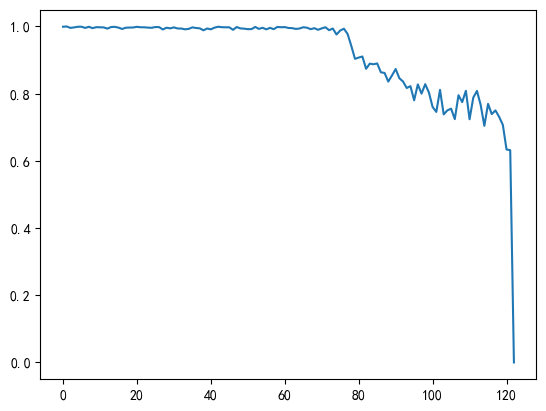

In [15]:
label1 = generate_label(label1)
plt.plot(label1)

In [16]:
T_data2 = scipy.io.loadmat('D:\数据集XJTU\西交大1-2水平.mat')['a']
T_data2 = T_data2[:, -2560:]
T_data2,label2,mean_1_std = feature_extraction(T_data2)

[[ 2.71479309e+00 -1.16819541e-02  2.75504182e-01 ...  3.09053051e+00
   5.39326409e-01  2.68834884e-01]
 [ 4.23383727e+00  3.99023112e-04  3.20480077e-01 ...  3.65822825e+00
   6.41359178e-01  3.10138368e-01]
 [ 4.60556594e+00 -8.13508939e-03  3.91182890e-01 ...  3.47203126e+00
   7.74230691e-01  3.72882388e-01]
 ...
 [ 3.17238655e+01 -5.31741282e-03  3.90509497e+00 ...  9.72180103e-01
   7.80487253e+00  1.32010757e+00]
 [ 3.55138039e+01  4.12622533e-02  3.64790862e+00 ...  1.66031160e+00
   7.33707950e+00  1.30323943e+00]
 [ 5.19686415e+01  2.33657948e-03  6.14135097e+00 ...  1.10190780e-01
   1.22850385e+01  1.40938232e+00]]
feature [  2.59184763   0.48009988  -0.46216857   1.59087609 -12.22721521
  71.09229286  95.69205842  67.36580934 -14.97576146  12.58352105
  -2.74221378]
cumulative_feature [  2.59184763   3.07194751   2.60977894   4.20065503  -8.02656019
  63.06573267 158.75779109 226.12360043 211.14783897 223.73136003
 220.98914625]
feature [  4.08061244   0.61329833  -0.5988

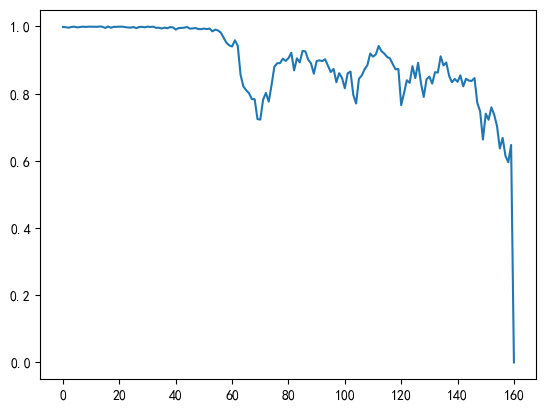

In [17]:
label2 = generate_label(label2)
plt.plot(label2)

In [18]:
T_data3 = scipy.io.loadmat('D:\数据集XJTU\西交大1-3水平.mat')['a']
T_data3 = T_data3[:, -2560:]
T_data3,label3,mean_1_std = feature_extraction(T_data3)

[[ 1.88550451e+00 -3.17078023e-02  2.10300322e-01 ...  1.17238022e+00
   3.88892842e-01  2.07279814e-01]
 [ 2.42300058e+00  3.01952295e-03  3.17189305e-01 ...  5.44524888e-01
   6.37398133e-01  3.07151254e-01]
 [ 1.18438133e+00 -1.70705791e-02  1.10268406e-01 ...  3.18641534e+00
   2.03466233e-01  1.09824716e-01]
 ...
 [ 2.53534773e+01  1.42272748e-02  2.12723087e+00 ...  1.48323929e+00
   4.26868901e+00  1.13135786e+00]
 [ 2.33915959e+01  3.56067084e-02  2.19805829e+00 ...  1.47897385e+00
   4.43172329e+00  1.14383611e+00]
 [ 2.17275333e+01 -5.85903262e-02  2.26801718e+00 ...  7.40897206e-01
   4.47744404e+00  1.15552415e+00]]
feature [ 1.77580434  0.40709285 -0.44790065  1.5295567  -5.51558982 44.02704484
 57.53234983 39.6740078  -9.20097054  7.30446001 -1.52161198]
cumulative_feature [  1.77580434   2.18289719   1.73499654   3.26455324  -2.25103658
  41.77600826  99.30835809 138.98236589 129.78139536 137.08585537
 135.56424339]
feature [  2.32193579   0.40727869  -0.28919945   1.298

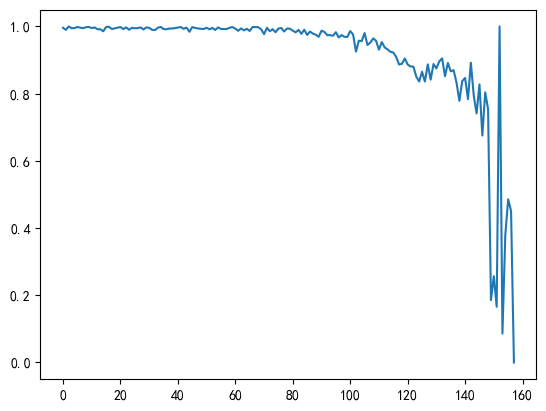

In [19]:
label3 = generate_label(label3)
plt.plot(label3)


In [20]:
T_data4 = scipy.io.loadmat('D:\数据集XJTU\西交大1-4水平.mat')['a']
T_data4 = T_data4[:, -2560:]
T_data4,label4,mean_1_std = feature_extraction(T_data4)

[[ 1.84091647e+00 -2.42538158e-02  2.21080298e-01 ...  1.60496983e+00
   4.17906781e-01  2.17580497e-01]
 [ 1.71431657e+00 -1.46642421e-03  1.93910667e-01 ...  2.12774191e+00
   3.86354910e-01  1.91533635e-01]
 [ 1.54670058e+00 -8.58432190e-03  1.89593261e-01 ...  1.15928257e+00
   3.70602199e-01  1.87369350e-01]
 ...
 [ 1.52664101e+00  2.39482304e-02  1.65273973e-01 ...  2.67488948e+00
   3.54496176e-01  1.63793319e-01]
 [ 1.43143943e+00 -8.02449933e-02  1.13394511e-01 ...  4.40218851e+00
   1.46544028e-01  1.12912206e-01]
 [ 2.79759204e+01 -5.22806585e-02  2.04481927e+00 ...  1.10137524e+01
   4.03735787e+00  1.11595447e+00]]
feature [ 1.74978562  0.34026961 -0.32570484  1.21559996 -7.47876524 46.71633741
 62.39169558 43.57819791 -9.95609904  8.12528603 -1.70926431]
cumulative_feature [  1.74978562   2.09005523   1.76435039   2.97995035  -4.49881489
  42.21752252 104.6092181  148.18741601 138.23131697 146.356603
 144.64733868]
feature [ 1.62607884  0.35148448 -0.33551568  1.20702391 

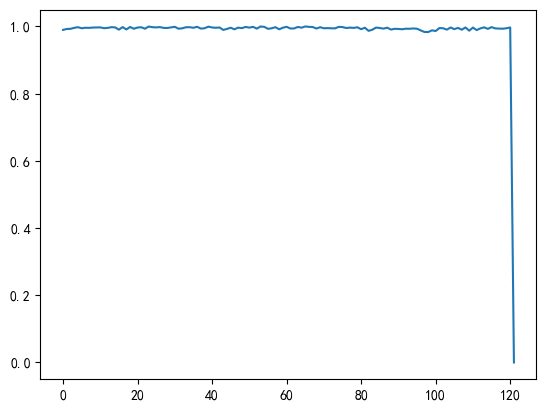

In [21]:
label4 = generate_label(label4)
plt.plot(label4)

In [22]:
T_data5 = scipy.io.loadmat('D:\数据集XJTU\西交大1-5水平.mat')['a']
T_data5 = T_data5[:, -2560:]
T_data5,label5,mean_1_std = feature_extraction(T_data5)

[[ 4.71733775e+00 -5.41373899e-03  4.55495035e-01  4.55527206e-01
   5.14098091e+00  5.14098091e+00  5.31212890e+02 -1.58943300e-02
   2.65719261e+00  9.05576331e-01  4.27414192e-01]
 [ 4.57845098e+00 -1.31639677e-02  5.87957412e-01  5.88104759e-01
   3.86845148e+00  3.86845148e+00  8.85420052e+02 -1.50424765e-02
   8.79547510e-01  1.16275086e+00  5.31517595e-01]
 [ 5.27983695e+00 -2.23052836e-03  6.60503828e-01  6.60507594e-01
   4.00052811e+00  4.00052811e+00  1.11685192e+03 -3.40584841e-02
   1.13476626e+00  1.31877713e+00  5.83723879e-01]
 [ 5.84157071e+00  4.48171713e-03  6.59397819e-01  6.59413050e-01
   5.13171188e+00  5.13171188e+00  1.11315346e+03 -4.35475206e-02
   1.07926949e+00  1.32327736e+00  5.82953428e-01]
 [ 4.19479520e+00 -3.13576629e-03  5.07536579e-01  5.07546266e-01
   4.53939760e+00  4.53939760e+00  6.59464223e+02  6.90787469e-02
   1.23114467e+00  1.01193739e+00  4.69658678e-01]
 [ 4.50349606e+00  2.24433471e-02  5.42025865e-01  5.42490315e-01
   4.08704310e+00  

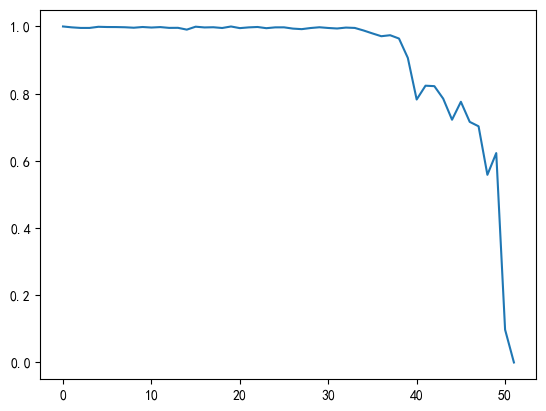

In [23]:
label5 = generate_label(label5)
plt.plot(label5)

# Visualize all the RUL labels generated for 5 bearings
Beautiful, isn't it?

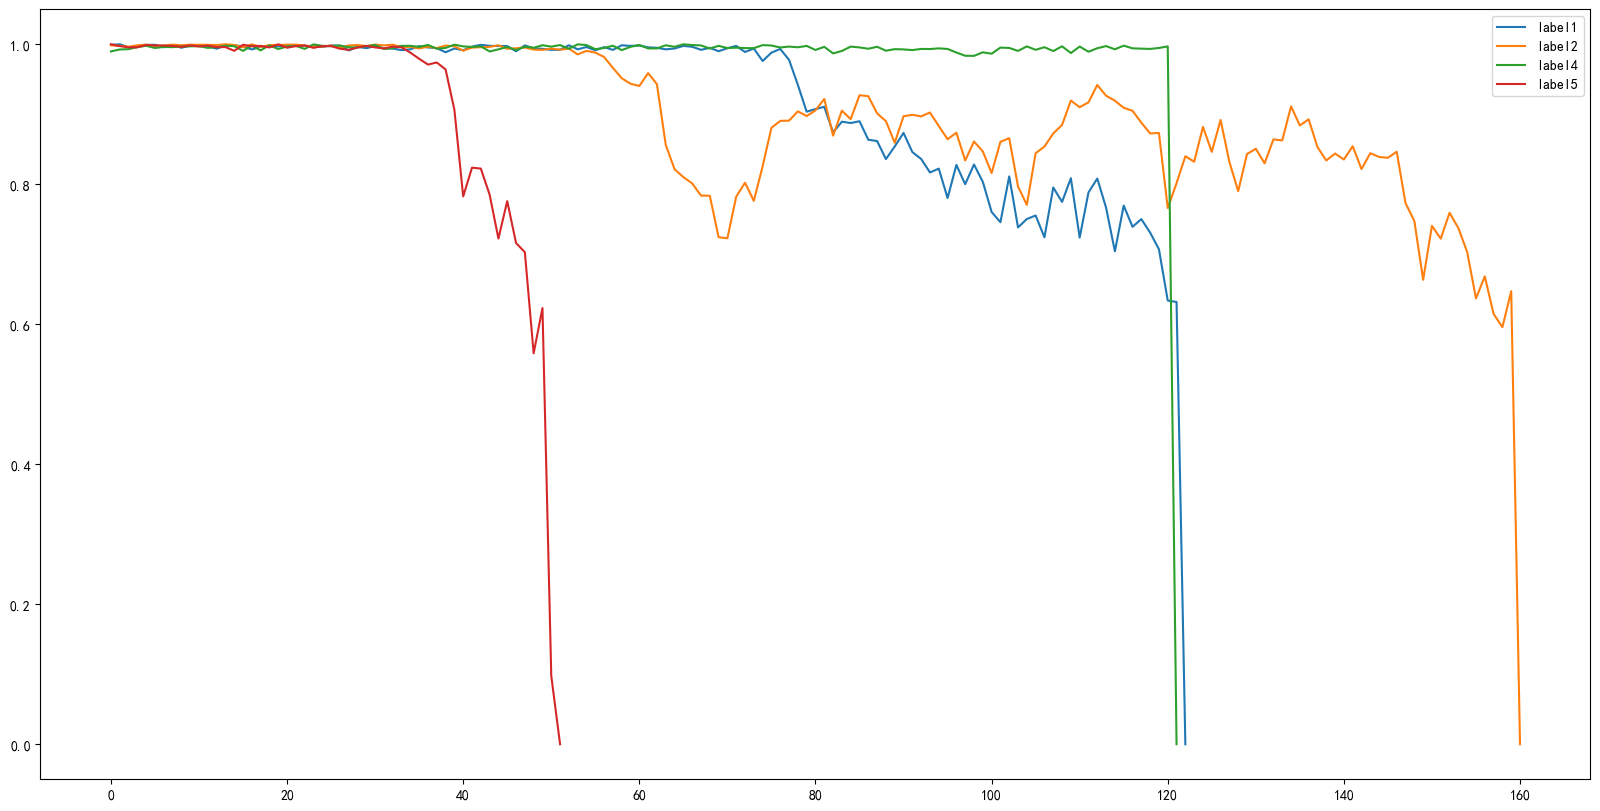

In [24]:
plt.figure(figsize=(20, 10))
plt.plot(label1,label='label1')
plt.plot(label2,label='label2')
plt.plot(label4,label='label4')
plt.plot(label5,label='label5')
plt.legend()
plt.show()

In [25]:
print('-----------------Stack bearing 1,2,3,4 as train set------------------------')
# trainX = np.vstack((T_data1,T_data2,T_data5))
trainX = np.vstack((T_data1,T_data2,T_data3,T_data4))
T_lable12 = np.append(label1,label2)
T_lable123 = np.append(T_lable12,label3)
# trainY = T_lable123
trainY = np.append(T_lable123,label4)
# trainY = np.append(trainY,label5[len(T_data5)//2:])
print('trainX',trainX.shape)
print('trainY',trainY.shape)

-----------------Stack bearing 1,2,3,4 as train set------------------------
trainX (564, 8)
trainY (564,)


# Load data for training and testing to torch

In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset


def traindata_loader(T_data, T_lable, T_data4, T_lable4):
    # 转化为tensor数据类型
    print(T_lable4)
    x_train = torch.Tensor(T_data)
    y_train = torch.Tensor(T_lable)
    x_val = torch.Tensor(T_data4)
    y_val = torch.Tensor(T_lable4)

    print("训练集的特征形状, x_train ：", x_train.shape)
    print("训练集的标签形状, y_train ：", y_train.shape)
    print("验证集的特征性状，x_val ：", x_val.shape)
    print("验证集的标签形状，y_val ：", y_val.shape)

    data_train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=64, shuffle=True, num_workers=0)
    data_val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=64, shuffle=False, num_workers=0)

    return data_train_loader, data_val_loader


data_train_loader, data_val_loader = traindata_loader(trainX, trainY, T_data5, label5)

[1.         0.99739449 0.99566524 0.99567281 0.99906544 0.99837168
 0.9982537  0.99769689 0.99629369 0.9984314  0.99685556 0.99819097
 0.99581856 0.99600916 0.99062514 0.99935887 0.9971384  0.99772074
 0.99546599 0.99997123 0.99509882 0.997311   0.99847981 0.99490523
 0.99736358 0.99744699 0.99366851 0.99206147 0.99541048 0.99766752
 0.99554202 0.99401607 0.99670277 0.99566697 0.9880224  0.97930637
 0.97099415 0.97399123 0.96410905 0.90641794 0.78264975 0.82374943
 0.82240996 0.78519942 0.7224724  0.775914   0.71609666 0.70296028
 0.55851968 0.62318389 0.09764606 0.        ]
训练集的特征形状, x_train ： torch.Size([564, 8])
训练集的标签形状, y_train ： torch.Size([564])
验证集的特征性状，x_val ： torch.Size([52, 8])
验证集的标签形状，y_val ： torch.Size([52])


In [27]:
from __future__ import print_function
import torch, gc
import torch.nn as nn
import os
import time
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

gc.collect()
torch.cuda.empty_cache()

Running on the GPU


# CNN

In [28]:
class CNNnet(nn.Module):
    def __init__(self):
        super(CNNnet, self).__init__()
        '''卷积池化'''
        self.localization = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=(3),stride=1,padding=1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, stride=2),
            nn.BatchNorm1d(64),
            # nn.Conv1d(64, 64, kernel_size=(3),stride=1,padding=1),
            
            nn.Conv1d(64, 64, kernel_size=(3),stride=1,padding=1),
            nn.LeakyReLU(),
            # nn.MaxPool1d(2, stride=2),
            # nn.BatchNorm1d(64),
            nn.Conv1d(64,128, kernel_size=(3),stride=1),
            nn.LeakyReLU(),
            # nn.MaxPool1d(2, stride=2),
            nn.Conv1d(128, 128, kernel_size=(1),stride=1),
            nn.LeakyReLU(),
            # nn.Conv1d(128, 128, kernel_size=(1),stride=1),
            # nn.ReLU(),
            # nn.BatchNorm1d(128),
        )
        '''全连接'''
        self.fc_loc = nn.Sequential(
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),# 添加dropout
            nn.BatchNorm1d(64),
          
            nn.Linear(64, 1),
            
            nn.Sigmoid()
        )


    def forward(self, x):
        x = x.to(torch.float32)
        '''卷积'''
        # print('x', x.shape)
        x0 = self.localization(x)
        # print('x0',x0.shape)
        '''全连接'''
        x_flat = x0.view(x0.size(0), -1)
        # print('x_flat', x_flat.shape)
        theta = self.fc_loc(x_flat)
        # print('theta', theta.shape)
        return theta

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 创建网络模型
model = CNNnet()


def Last_evaluate2(net, loader):
    net.eval()
    min_val_loss = 0.0
    preds = []
    true = []
    i = 0
    with torch.no_grad():
        for data, target in loader:
            print(target)
            data=data.view(len(data),1,8)
            data, target = data.to(device), target.to(device)
            output = net(data)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())
            min_val_loss += Losses(output, target).item()
            i += 1
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        return np.round(preds, 4), np.round(true, 5)
steps = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
Losses = nn.MSELoss()
model.to(device)  # 模型转到GPU

cuda


CNNnet(
  (localization): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (9): LeakyReLU(negative_slope=0.01)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

epoch [1/100], loss:0.182572,  lr:0.001
epoch [2/100], loss:0.138445,  lr:0.001
epoch [3/100], loss:0.117134,  lr:0.001
epoch [4/100], loss:0.102359,  lr:0.001
epoch [5/100], loss:0.104812,  lr:0.001
epoch [6/100], loss:0.096994,  lr:0.001
epoch [7/100], loss:0.078488,  lr:0.001
epoch [8/100], loss:0.070533,  lr:0.001
epoch [9/100], loss:0.059886,  lr:0.001
epoch [10/100], loss:0.058050,  lr:0.001
epoch [11/100], loss:0.063793,  lr:0.0009000000000000001
epoch [12/100], loss:0.042710,  lr:0.0009000000000000001
epoch [13/100], loss:0.044253,  lr:0.0009000000000000001
epoch [14/100], loss:0.036628,  lr:0.0009000000000000001
epoch [15/100], loss:0.036311,  lr:0.0009000000000000001
epoch [16/100], loss:0.049918,  lr:0.0009000000000000001
epoch [17/100], loss:0.079837,  lr:0.0009000000000000001
epoch [18/100], loss:0.062917,  lr:0.0009000000000000001
epoch [19/100], loss:0.043411,  lr:0.0009000000000000001
epoch [20/100], loss:0.050065,  lr:0.0009000000000000001
epoch [21/100], loss:0.042689

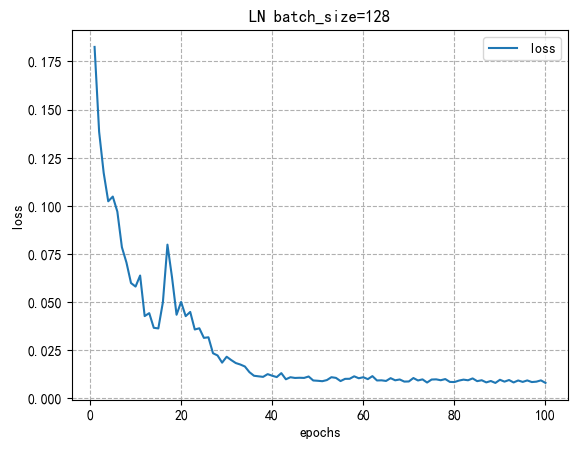

tensor([1.0000, 0.9974, 0.9957, 0.9957, 0.9991, 0.9984, 0.9983, 0.9977, 0.9963,
        0.9984, 0.9969, 0.9982, 0.9958, 0.9960, 0.9906, 0.9994, 0.9971, 0.9977,
        0.9955, 1.0000, 0.9951, 0.9973, 0.9985, 0.9949, 0.9974, 0.9974, 0.9937,
        0.9921, 0.9954, 0.9977, 0.9955, 0.9940, 0.9967, 0.9957, 0.9880, 0.9793,
        0.9710, 0.9740, 0.9641, 0.9064, 0.7826, 0.8237, 0.8224, 0.7852, 0.7225,
        0.7759, 0.7161, 0.7030, 0.5585, 0.6232, 0.0976, 0.0000])
y_test_true5 (52,)


In [30]:
T_val_loss = 9999
counter = 0
epochs=100
train_loss = []
train_flood = []
val_loss = []
all_epochs = []
lr_step = []
###这个是模型权重的保存
save_dir = "model/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
t1=time.time()
for epoch in range(1, epochs + 1):
    epoch_loss = 0
    flood_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(data_train_loader):
        # print(data.shape)
        data=data.view(len(data),1,8)
        # print(data.shape)
        total = 0
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze(1)
        loss = Losses(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total = batch_idx + 1
    epoch_loss = epoch_loss / total


    lr_current = optimizer.param_groups[0]['lr']
    lr_step.append(lr_current)
    epoch_scheduler.step()
    print('epoch [{}/{}], loss:{:6f},  lr:{}'.format(epoch, epochs,epoch_loss,lr_current))  # {:.4f}
    ##这里是保存最后一个epoch的权重
    # torch.save(model.state_dict(), os.path.join(save_dir, "model_on_last_epoch.pth"))

    if epoch % 1 == 0:
        train_loss.append(epoch_loss)
        all_epochs.append(epoch)
    """这里是设置训练的early stop patience """
    # 对测试集上的test_loss进行监视，并设置patience，保存在测试集上表现最好的model
t2=time.time()
train_time=t2-t1

#训练loss查看
plt.grid(linestyle="--")
plt.plot(all_epochs,train_loss)
plt.title("LN batch_size=128")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss'],loc='upper right')
plt.show()


'''预测评估'''
#RUL预测与可视化

y_test_preds5, y_test_true5 = Last_evaluate2(model, data_val_loader)

print('y_test_true5', y_test_true5.shape)

均方根误差RMSE: 0.048270
平均绝对误差MAE: 0.038023
得分Score: 0.939736
准确率Accuracy: 0.923077


C:\Users\wyh\AppData\Local\Temp\ipykernel_25444\640050528.py:12: RuntimeWarning: invalid value encountered in divide
  abs_error = np.abs(y_true - y_pred) / np.abs(y_true)


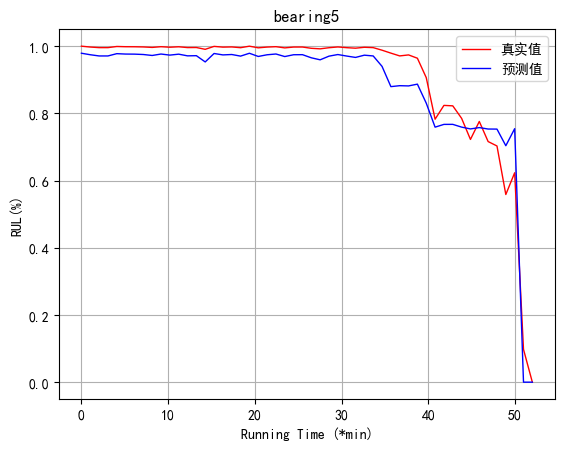

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def myPlot(y_true, y_pred, unit):
    mse = mean_squared_error(y_pred, y_true)
    rmse = pow(mse, 0.5)
    print('均方根误差RMSE: %.6f' % rmse)
    Mae = mean_absolute_error(y_pred, y_true)
    print('平均绝对误差MAE: %.6f' % Mae)
    Score = r2_score(y_pred, y_true)
    print('得分Score: %.6f' % Score)
    abs_error = np.abs(y_true - y_pred) / np.abs(y_true)
    num_accurate = np.sum(abs_error <= 0.15)
    accuracy = num_accurate / len(y_true)
    print('准确率Accuracy: %.6f' % accuracy)
    x = np.linspace(0, (len(y_true)), len(y_true))
    plt.plot(x, y_true, color='red', label='真实值', linewidth='1')
    plt.plot(x, y_pred, color='blue', label='预测值', linewidth='1')
    plt.legend()
    plt.grid('--')
    plt.title(fr'bearing{unit}')
    plt.ylabel('RUL(%)')
    plt.xlabel('Running Time (*min)')
    plt.show()
    return mse, rmse, Score, accuracy


# y_test_preds5 = (y_test_preds5 - np.min(y_test_preds5)) / (np.max(y_test_preds5) - np.min(y_test_preds5))
mse, rmse, score, accuracy = myPlot(label5, y_test_preds5, 5)


In [32]:
CNN_info={}
CNN_info['train_time']=train_time
CNN_info['mse']=mse
CNN_info['rmse']=rmse
CNN_info['score']=score
CNN_info['accuracy']=accuracy

# CNN+ResNet

In [33]:
import torch.nn.functional as F  

class ResidualBlock(nn.Module):  
    def __init__(self, filters, conv_size):  
        super(ResidualBlock, self).__init__()  
        self.conv1 = nn.Conv1d(filters, filters, conv_size, padding='same')  
        self.bn1 = nn.BatchNorm1d(filters)  
        self.conv2 = nn.Conv1d(filters, filters, conv_size, padding='same')  
        self.bn2 = nn.BatchNorm1d(filters)  

    def forward(self, x):  
        identity = x  
        out = self.conv1(x)  
        out = F.relu(self.bn1(out))  
        out = self.conv2(out)  
        out = self.bn2(out)  
        out += identity  
        out = F.relu(out)  
        return out  

class CNN_ResNet_model(nn.Module):  
    def __init__(self, label_num, num_b, data_shape=(8, 1)):  
        super(CNN_ResNet_model, self).__init__()  
        self.num_blocks = num_b  
        self.filters = 64  
        self.conv_size = 3  
        self.label_num = label_num  

        # Initial Conv Layers  
        self.conv1 = nn.Conv1d(data_shape[1], 32, 3, padding='same')  
        self.conv2 = nn.Conv1d(32, 64, 3, padding='same')  
        self.bn1=nn.BatchNorm1d(64)
        # Pooling Layer  
        self.pool = nn.MaxPool1d(4)  

        # ResNet Blocks  
        self.res_blocks = nn.ModuleList([ResidualBlock(self.filters, self.conv_size) for _ in range(self.num_blocks)])  

        # Additional Conv Layer after ResNet Blocks  
        self.conv3 = nn.Conv1d(64, 64, 3, padding='same')  
    
        # Global Average Pooling  
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  

        # Fully connected layers  
        self.fc1 = nn.Linear(64, 256)  
        # self.bn2=nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.1)  
        self.fc2 = nn.Linear(256, 1)  

    def forward(self, x):  
        x = F.relu(self.conv1(x))  
        x = F.relu(self.conv2(x))  
        x = self.pool(x)  
        x = self.bn1(x)
        for block in self.res_blocks:  
            x = block(x)  

        x = F.relu(self.conv3(x))  
        x = self.global_avg_pool(x)  
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer  
        x = F.relu(self.fc1(x))  
        x = self.dropout(x)
        # x = self.bn2(x)
        x = self.fc2(x)  
        x = F.sigmoid(x)

        return x  

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 创建网络模型
model = CNN_ResNet_model(label_num=1, num_b=4)

cuda


In [35]:
def Last_evaluate2(net, loader):
    net.eval()
    min_val_loss = 0.0
    preds = []
    true = []
    i = 0
    with torch.no_grad():
        for data, target in loader:
            print(target)
            data = data.view(len(data), 1, 8)
            data, target = data.to(device), target.to(device)
            output = net(data)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())
            min_val_loss += Losses(output, target).item()
            i += 1
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        return np.round(preds, 4), np.round(true, 5)


steps = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.9)
Losses = nn.MSELoss()
model.to(device)  # 模型转到GPU

CNN_ResNet_model(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (res_blocks): ModuleList(
    (0): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
      

In [36]:
T_val_loss = 9999
counter = 0
epochs = 150
train_loss = []
train_flood = []
val_loss = []
all_epochs = []
lr_step = []
###这个是模型权重的保存
save_dir = "model/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
t1 = time.time()
for epoch in range(1, epochs + 1):
    epoch_loss = 0
    flood_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(data_train_loader):
        # print(data.shape)
        data = data.view(len(data), 1, 8)
        # print(data.shape)
        total = 0
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze(1)
        # output = (output - torch.min(output)) / (torch.max(output) - torch.min(output))
        loss = Losses(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        total = batch_idx + 1
    epoch_loss = epoch_loss / total

    lr_current = optimizer.param_groups[0]['lr']
    lr_step.append(lr_current)
    epoch_scheduler.step()
    print('epoch [{}/{}], loss:{:6f},  lr:{}'.format(epoch, epochs, epoch_loss, lr_current))  # {:.4f}
    ##这里是保存最后一个epoch的权重
    # torch.save(model.state_dict(), os.path.join(save_dir, "model_on_last_epoch.pth"))

    if epoch % 1 == 0:
        train_loss.append(epoch_loss)
        all_epochs.append(epoch)
    """这里是设置训练的early stop patience """
    # 对测试集上的test_loss进行监视，并设置patience，保存在测试集上表现最好的model
t2 = time.time()
train_time = t2 - t1

C:\Users\wyh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch [1/150], loss:0.174019,  lr:0.0001
epoch [2/150], loss:0.138747,  lr:0.0001
epoch [3/150], loss:0.102737,  lr:0.0001
epoch [4/150], loss:0.069355,  lr:0.0001
epoch [5/150], loss:0.043540,  lr:0.0001
epoch [6/150], loss:0.026041,  lr:0.0001
epoch [7/150], loss:0.017593,  lr:0.0001
epoch [8/150], loss:0.013659,  lr:9e-05
epoch [9/150], loss:0.011827,  lr:9e-05
epoch [10/150], loss:0.011112,  lr:9e-05
epoch [11/150], loss:0.010176,  lr:9e-05
epoch [12/150], loss:0.010302,  lr:9e-05
epoch [13/150], loss:0.009280,  lr:9e-05
epoch [14/150], loss:0.011264,  lr:9e-05
epoch [15/150], loss:0.009721,  lr:8.1e-05
epoch [16/150], loss:0.009055,  lr:8.1e-05
epoch [17/150], loss:0.008806,  lr:8.1e-05
epoch [18/150], loss:0.008320,  lr:8.1e-05
epoch [19/150], loss:0.008527,  lr:8.1e-05
epoch [20/150], loss:0.008821,  lr:8.1e-05
epoch [21/150], loss:0.008219,  lr:8.1e-05
epoch [22/150], loss:0.007882,  lr:7.290000000000001e-05
epoch [23/150], loss:0.008033,  lr:7.290000000000001e-05
epoch [24/150

# Plot train loss_epoch curve

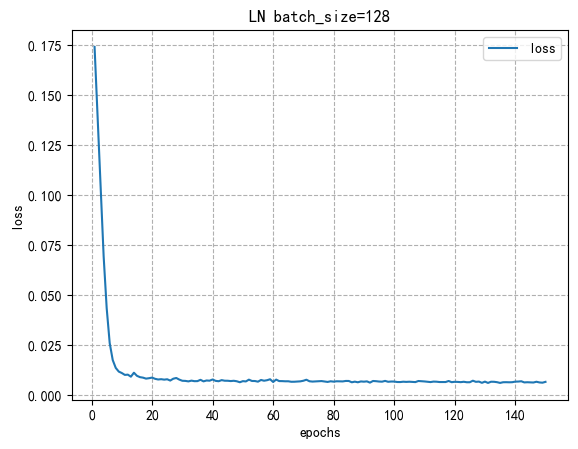

In [37]:
#训练loss查看
plt.grid(linestyle="--")
plt.plot(all_epochs, train_loss)
plt.title("LN batch_size=128")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss'], loc='upper right')
plt.show()

tensor([1.0000, 0.9974, 0.9957, 0.9957, 0.9991, 0.9984, 0.9983, 0.9977, 0.9963,
        0.9984, 0.9969, 0.9982, 0.9958, 0.9960, 0.9906, 0.9994, 0.9971, 0.9977,
        0.9955, 1.0000, 0.9951, 0.9973, 0.9985, 0.9949, 0.9974, 0.9974, 0.9937,
        0.9921, 0.9954, 0.9977, 0.9955, 0.9940, 0.9967, 0.9957, 0.9880, 0.9793,
        0.9710, 0.9740, 0.9641, 0.9064, 0.7826, 0.8237, 0.8224, 0.7852, 0.7225,
        0.7759, 0.7161, 0.7030, 0.5585, 0.6232, 0.0976, 0.0000])
均方根误差RMSE: 0.057076
平均绝对误差MAE: 0.036210
得分Score: 0.936683
准确率Accuracy: 0.884615


C:\Users\wyh\AppData\Local\Temp\ipykernel_25444\1224787369.py:9: RuntimeWarning: invalid value encountered in divide
  abs_error = np.abs(y_true - y_pred) / np.abs(y_true)


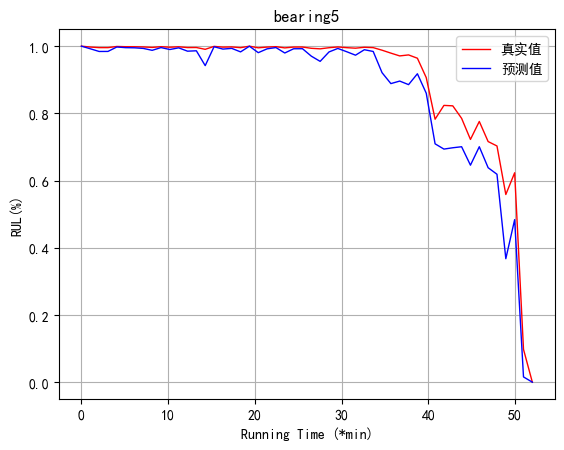

In [38]:
def myPlot(y_true, y_pred, unit):
    mse = mean_squared_error(y_pred, y_true)
    rmse = pow(mse, 0.5)
    print('均方根误差RMSE: %.6f' % rmse)
    Mae = mean_absolute_error(y_pred, y_true)
    print('平均绝对误差MAE: %.6f' % Mae)
    Score = r2_score(y_pred, y_true)
    print('得分Score: %.6f' % Score)
    abs_error = np.abs(y_true - y_pred) / np.abs(y_true)
    num_accurate = np.sum(abs_error <= 0.15)
    accuracy = num_accurate / len(y_true)
    print('准确率Accuracy: %.6f' % accuracy)
    
    x = np.linspace(0, (len(y_true)), len(y_true))
    plt.plot(x, y_true, color='red', label='真实值', linewidth='1')
    plt.plot(x, y_pred, color='blue', label='预测值', linewidth='1')
    plt.legend()
    plt.grid('--')
    plt.title(fr'bearing{unit}')
    plt.ylabel('RUL(%)')
    plt.xlabel('Running Time (*min)')
    plt.show()
    return mse, rmse, Score,accuracy
y_test_preds5, y_test_true5 = Last_evaluate2(model, data_val_loader)
y_test_preds5 = (y_test_preds5 - np.min(y_test_preds5)) / (np.max(y_test_preds5) - np.min(y_test_preds5))
mse, rmse, score,accuracy = myPlot(label5, y_test_preds5, 5)

In [39]:

CNN_ResNet_info = {}
CNN_ResNet_info['train_time'] = train_time
CNN_ResNet_info['mse'] = mse
CNN_ResNet_info['rmse'] = rmse
CNN_ResNet_info['score'] = score
CNN_ResNet_info['accuracy'] = accuracy

# Transformer

for some datasets nhead=2 will be more efficient

In [63]:
import torch.optim as optim


class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=256,
                 dropout=0.1):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(
            d_model=input_dim,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.fc_out = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src, tgt):
        # src shape: (seq_length, batch_size, d_model)  
        # tgt shape: (seq_length, batch_size, d_model)  
        output = self.transformer(src, tgt)
        output = self.fc_out(output[-1])  # output[-1] 是最后一个时间步的输出
        output = self.sigmoid(output)
        return output  # output[-1] 是最后一个时间步的输出


d_model = 8


def create_tensors(data_loader):
    for data, target in data_loader:
        # print(f"Original data shape: {data.shape}, target shape: {target.shape}")  

        # data shape: (batch_size, seq_length, input_dim)  
        # target shape: (batch_size, 1)  
        data = data.unsqueeze(1)
        # 确保数据在最后一个维度与d_model一致  
        if data.size(-1) != d_model:
            # 如果不一致，则需要进行适当的处理，比如线性变换或填充  
            data = data.view(-1, 1, d_model)  # 这里你可能需要更多的处理  

        # 将目标转为 (batch_size, seq_length=1, d_model)  
        tgt = target.view(-1, 1, 1)  # 目标还原为这样的形状  
        tgt = tgt.repeat(1, 1, d_model)  # 扩展到 (batch_size, seq_length=1, d_model)  

        assert data.size(-1) == d_model, "The last dimension of data must match d_model"
        assert tgt.size(-1) == d_model, "The last dimension of tgt must match d_model"

        yield data.permute(1, 0, 2), tgt.permute(1, 0, 2)  # 返回 (seq_length, batch_size, dim)


def train_model(model, train_loader, val_loader, epochs=200, lr=0.002):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    criterion = nn.MSELoss()
    train_loss_list = []
    val_loss_list = []
    all_epochs = []
    # 用于存储验证集的真实值和预测值  
    all_y_true = []
    all_y_pred = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for src, tgt in create_tensors(train_loader):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            outputs = model(src, tgt)
            # print('outputs',outputs)
            loss = criterion(outputs, tgt[-1])  # 使用目标最后一个时间步计算损失  
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')
        train_loss_list.append(avg_loss)
        all_epochs.append(epoch)
        # scheduler.step()

        # 验证  
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for src, tgt in create_tensors(val_loader):
                src, tgt = src.to(device), tgt.to(device)
                outputs = model(src, tgt)
                loss = criterion(outputs, tgt[-1])
                val_loss += loss.item()
                all_y_true.append(tgt[-1].cpu().numpy())  # 真实值  
                all_y_pred.append(outputs.cpu().numpy())  # 预测值 
        avg_val_loss = val_loss / len(val_loader)
        print(f'Validation Loss: {avg_val_loss}')
        val_loss_list.append(avg_val_loss)
        scheduler.step()
    return train_loss_list, val_loss_list, all_epochs, all_y_true, all_y_pred 

In [64]:
# 创建模型实例并开始训练  
input_dim = 8  # 输入特征维度
output_dim = 1  # 输出维度  
model = TransformerModel(input_dim=input_dim, output_dim=output_dim)
print(model)

TransformerModel(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
          )
          (linear1): Linear(in_features=8, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=8, bias=True)
          (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
          )
          (linear1): Linear(in_features=8, out_features=

C:\Users\wyh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 8])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\wyh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([52, 8])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/200, Loss: 0.08925896055168575
Validation Loss: 0.044820066541433334
Epoch 2/200, Loss: 0.02519004750582907
Validation Loss: 0.04320376366376877
Epoch 3/200, Loss: 0.023258123857279617
Validation Loss: 0.04240557178854942
Epoch 4/200, Loss: 0.021499120112922456
Validation Loss: 0.041859615594148636
Epoch 5/200, Loss: 0.020567148716913328
Validation Loss: 0.041566312313079834
Epoch 6/200, Loss: 0.020737628762920696
Validation Loss: 0.041401173919439316
Epoch 7/200, Loss: 0.020288568197025195
Validation Loss: 0.04132895544171333
Epoch 8/200, Loss: 0.01935638047547804
Validation Loss: 0.04130788519978523
Epoch 9/200, Loss: 0.01914403411663241
Validation Loss: 0.04132330045104027
Epoch 10/200, Loss: 0.019256512479235727
Validation Loss: 0.04135197028517723
Epoch 11/200, Loss: 0.01872955955978897
Validation Loss: 0.041380058974027634
Epoch 12/200, Loss: 0.01917215535003278
Validation Loss: 0.04140723869204521
Epoch 13/200, Loss: 0.01887231744411919
Validation Loss: 0.041430007666349

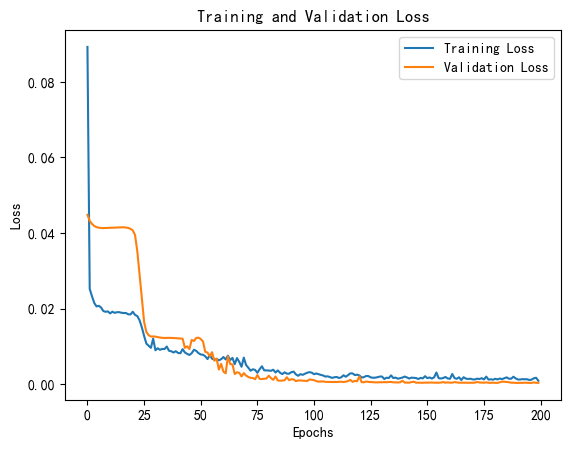

In [65]:
model.to(device)  # 将模型转移到可用的设备上  
t1 = time.time()
train_loss, val_loss, all_epochs, y_val, y_pred = train_model(model, data_train_loader, data_val_loader)
t2 = time.time()
train_time = t2 - t1
# 绘制训练和验证损失曲线

def plot_loss(train_loss, val_loss):
    plt.plot(np.arange(len(train_loss)), train_loss, label='Training Loss')
    plt.plot(np.arange(len(val_loss)), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


plot_loss(train_loss, val_loss)

In [66]:
def evaluate_model(model, test_loader):
    model.eval()
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for src, tgt in create_tensors(test_loader):
            src, tgt = src.to(device), tgt.to(device)
            outputs = model(src, tgt)
            all_y_true.append(tgt[-1].cpu().numpy().flatten())  # 将真实值平坦化  
            all_y_pred.append(outputs.cpu().numpy().flatten())  # 将预测值平坦化  

    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)
    print('y_pred', y_pred)
    return y_true, y_pred


def plot_results(y_true, y_pred):
    y_true = y_true.flatten()  # 确保是平坦的数组  
    y_pred = y_pred.flatten()  # 确保是平坦的数组  

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    abs_error = np.abs(y_true - y_pred) / np.abs(y_true)
    num_accurate = np.sum(abs_error <= 0.15)
    accuracy = num_accurate / len(y_true)

    print(f'均方根误差 RMSE: {rmse:.6f}')
    print(f'平均绝对误差 MAE: {mae:.6f}')
    print(f'R²得分: {r2:.6f}')
    print(f'准确率 Accuracy: {accuracy:.6f}')
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, color='red', label='真实值', linewidth=1)
    plt.plot(range(len(y_pred)), y_pred, color='blue', label='预测值', marker='o')
    plt.legend()
    plt.title('Bearing 5 ')
    plt.xlabel('Running Time(*min)')
    plt.ylabel('RUL(%)')
    plt.grid()
    plt.show()
    return mse, rmse, r2, accuracy

y_pred [0.9821124  0.982107   0.98210126 0.98210126 0.9821109  0.9821094
 0.9821092  0.9821078  0.9821034  0.98210955 0.98210526 0.98210895
 0.9821018  0.9821025  0.982074   0.98211145 0.9821062  0.9821078
 0.9821004  0.9821124  0.98209906 0.9821066  0.98210967 0.9820983
 0.98210686 0.9821071  0.9820925  0.98208356 0.9821002  0.9821077
 0.9821008  0.9820942  0.98210484 0.98210126 0.9820524  0.981926
 0.9816581  0.98177904 0.98114324 0.8993047  0.782609   0.8118931
 0.81095254 0.7844727  0.739813   0.77762586 0.73525035 0.7254441
 0.50949556 0.6341638  0.07548969 0.06992695]
y_test_true 416
y_test_preds 52
均方根误差 RMSE: 0.019030
平均绝对误差 MAE: 0.009151
R²得分: 0.991242
准确率 Accuracy: 0.961538


C:\Users\wyh\AppData\Local\Temp\ipykernel_25444\1143321140.py:27: RuntimeWarning: invalid value encountered in divide
  abs_error = np.abs(y_true - y_pred) / np.abs(y_true)


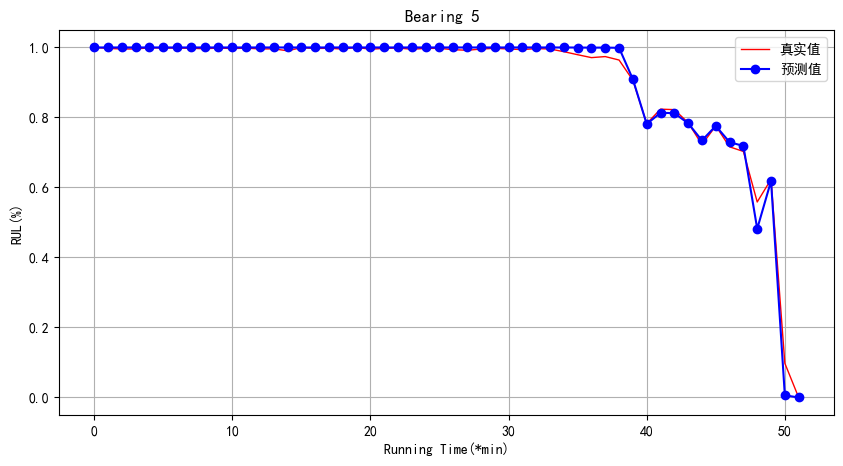

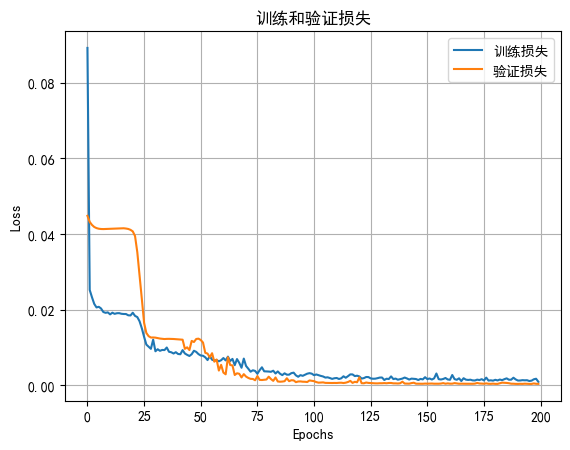

In [67]:


# 模型评估（使用测试集或验证集即可）  
y_test_true, y_test_preds = evaluate_model(model, data_val_loader)  # 这里的数据集可定义为测试集
y_test_preds = (y_test_preds - np.min(y_test_preds)) / (np.max(y_test_preds) - np.min(y_test_preds))
print('y_test_true', len(y_test_true))
print('y_test_preds', len(y_test_preds))
# 绘制结果  
mse, rmse, score, accuracy = plot_results(label5, y_test_preds)
# 绘制损失曲线  
plt.plot(all_epochs, train_loss, label='训练损失')
plt.plot(all_epochs, val_loss, label='验证损失')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('训练和验证损失')
plt.legend()
plt.grid()
plt.show()  

In [68]:
Transformer_info={}
Transformer_info['train_time']=train_time
Transformer_info['mse']=mse
Transformer_info['rmse']=rmse
Transformer_info['score']=score
Transformer_info['accuracy']=accuracy

# Traditional Machine Learing algorithms

In [46]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error  
# trainY = np.append(T_lable123,label5)
# 假设 trainX 和 trainY 已经准备好  
X = trainX  # 输入特征  
print('X',X.shape)
y = trainY  # 输出标签  
print('y',y.shape)
# 数据分割为训练集和验证集  
X_train, X_val= trainX, T_data5
y_train, y_val = trainY, label5

X (564, 8)
y (564,)


Mean Squared Error: 0.0025
均方根误差RMSE: 0.050091
平均绝对误差MAE: 0.042745
得分Score: 0.939319
准确率Accuracy: 0.980769


C:\Users\wyh\AppData\Local\Temp\ipykernel_25444\3699002299.py:23: RuntimeWarning: divide by zero encountered in divide
  abs_error = np.abs(y_true - y_pred) / np.abs(y_true)


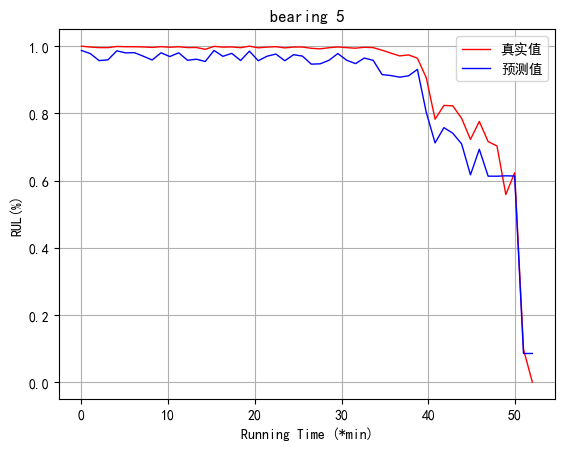

In [47]:
# 创建和拟合随机森林模型  
model = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=10)
t1=time.time()
model.fit(X_train, y_train)  
t2=time.time()
train_time=t2-t1
# 进行预测  
y_pred = model.predict(X_val)  

# 评估模型性能  
mse = mean_squared_error(y_val, y_pred)  
print(f'Mean Squared Error: {mse:.4f}')  

# 自定义可视化函数  
def myPlot(y_true, y_pred, unit):  
    mse = mean_squared_error(y_true, y_pred)  
    rmse = np.sqrt(mse)  
    print('均方根误差RMSE: %.6f' % rmse)  
    mae = mean_absolute_error(y_true, y_pred)  
    print('平均绝对误差MAE: %.6f' % mae)  
    score = r2_score(y_true, y_pred)  
    print('得分Score: %.6f' % score)  
    abs_error = np.abs(y_true - y_pred) / np.abs(y_true)
    num_accurate = np.sum(abs_error <= 0.15)
    accuracy = num_accurate / len(y_true)
    print('准确率Accuracy: %.6f' % accuracy)
    x = np.linspace(0, len(y_true), len(y_true))  
    plt.plot(x, y_true, color='red', label='真实值', linewidth=1)  
    plt.plot(x, y_pred, color='blue', label='预测值', linewidth=1)  
    plt.legend()  
    plt.grid('--')  
    plt.title(fr'bearing {unit}')  
    plt.ylabel('RUL(%)')  
    plt.xlabel('Running Time (*min)')  
    plt.show()  

    return mse, rmse, score,accuracy 
# y_pred=(y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred))
# 调用可视化函数  
mse,rmse,score,accuracy=myPlot(y_val, y_pred, 5)  

In [48]:
RF_info={}
RF_info['train_time']=train_time
RF_info['mse']=mse
RF_info['rmse']=rmse
RF_info['score']=score
RF_info['accuracy']=accuracy

# Support Vector Regression (THIS IS THE MODEL THAT GIVES THE BEST PERFORMANCE)

SVR's R2_score and error is almost the same as the Transformer model, but SVR will run way much faster than Transformer model

* BTW, SVM is also the model of best performance in bearing fault diagnostic tasks

y_train (564,)
(564,)
Mean Squared Error: 0.0266
均方根误差RMSE: 0.000077
平均绝对误差MAE: 0.000047
得分Score: 1.000000
准确率Accuracy: 0.980769


C:\Users\wyh\AppData\Local\Temp\ipykernel_25444\2262562411.py:40: RuntimeWarning: invalid value encountered in divide
  abs_error = np.abs(y_true - y_pred) / np.abs(y_true)


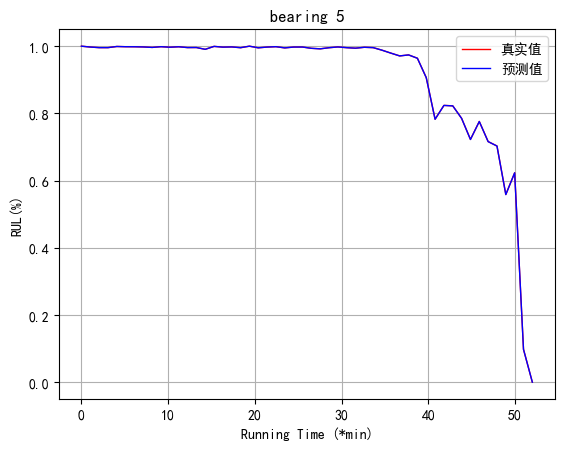

In [49]:
from sklearn.svm import SVR  
# 数据分割为训练集和验证集  
X_train, X_val = trainX, T_data5
y_train, y_val = trainY, label5
print('y_train',y_train.shape)
# 创建标准化对象  
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 数据标准化  
X_train = scaler_X.fit_transform(X_train)  
X_val = scaler_X.transform(X_val)  
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()  
print(y_train.shape)
t1=time.time()
# 创建和拟合支持向量回归模型  
model = SVR(kernel='linear', C=2, gamma='scale',degree=3)  
model.fit(X_train, y_train)  
t2=time.time()
train_time=t2-t1
# 进行预测  
y_pred = model.predict(X_val)  

# 反标准化预测结果  
# y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()  
# y_pred=(y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred))
# 评估模型性能  
mse = mean_squared_error(y_val, y_pred)  
print(f'Mean Squared Error: {mse:.4f}')  

# 自定义可视化函数  
def myPlot(y_true, y_pred, unit):  
    mse = mean_squared_error(y_true, y_pred)  
    rmse = np.sqrt(mse)  
    print('均方根误差RMSE: %.6f' % rmse)  
    mae = mean_absolute_error(y_true, y_pred)  
    print('平均绝对误差MAE: %.6f' % mae)  
    score = r2_score(y_true, y_pred)  
    print('得分Score: %.6f' % score)  
    abs_error = np.abs(y_true - y_pred) / np.abs(y_true)
    num_accurate = np.sum(abs_error <= 0.15)
    accuracy = num_accurate / len(y_true)
    print('准确率Accuracy: %.6f' % accuracy)
    # 可视化  
    x = np.linspace(0, len(y_true), len(y_true))  
    plt.plot(x, y_true, color='red', label='真实值', linewidth=1)  
    plt.plot(x, y_pred, color='blue', label='预测值',linewidth=1)  
    plt.legend()  
    plt.grid('--')  
    plt.title(fr'bearing {unit}')  
    plt.ylabel('RUL(%)')  
    plt.xlabel('Running Time (*min)')  
    plt.show()  

    return mse,rmse,score,accuracy
y_pred=(y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred))
# 调用可视化函数  
mse,rmse,score,accuracy=myPlot(y_val, y_pred, 5)


In [50]:
SVR_info={}
SVR_info['train_time']=train_time
SVR_info['mse']=mse
SVR_info['rmse']=rmse
SVR_info['score']=score
SVR_info['accuracy']=accuracy

# KNN Regression

In [51]:
from sklearn.neighbors import KNeighborsRegressor  

C:\Users\wyh\AppData\Local\Temp\ipykernel_25444\425425358.py:40: RuntimeWarning: divide by zero encountered in divide
  abs_error = np.abs(y_true - y_pred) / np.abs(y_true)


Mean Squared Error: 0.0058
均方根误差RMSE: 0.076346
平均绝对误差MAE: 0.045268
得分Score: 0.859037
准确率Accuracy: 0.961538


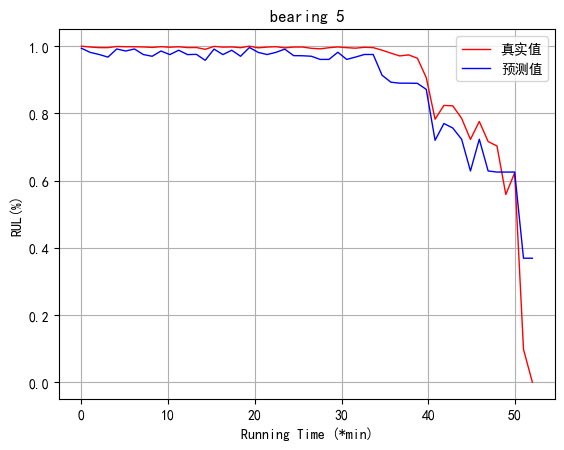

In [52]:
X_train, X_val = trainX, T_data5
y_train, y_val = trainY, label5

# 数据标准化（可选）  
scaler_X = MinMaxScaler()  
scaler_y = MinMaxScaler()  

X_train = scaler_X.fit_transform(X_train)  
X_val = scaler_X.transform(X_val)  
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()  

# 创建 KNN 模型  
k = 5  # 选择适当的 K 值  

model = KNeighborsRegressor(n_neighbors=k)  
t1=time.time()
# 训练模型  
model.fit(X_train, y_train)  
t2=time.time()
train_time=t2-t1
# 进行预测  
y_pred = model.predict(X_val)  

# 反标准化预测结果  
# y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()  

# 评估模型性能  
mse = mean_squared_error(y_val, y_pred)  
print(f'Mean Squared Error: {mse:.4f}')  

# 自定义可视化函数  
def myPlot(y_true, y_pred, unit):  
    mse = mean_squared_error(y_true, y_pred)  
    rmse = np.sqrt(mse)  
    print('均方根误差RMSE: %.6f' % rmse)  
    mae = mean_absolute_error(y_true, y_pred)  
    print('平均绝对误差MAE: %.6f' % mae)  
    score = r2_score(y_true, y_pred)  
    print('得分Score: %.6f' % score)  
    abs_error = np.abs(y_true - y_pred) / np.abs(y_true)
    num_accurate = np.sum(abs_error <= 0.15)
    accuracy = num_accurate / len(y_true)
    print('准确率Accuracy: %.6f' % accuracy)
    # 可视化  
    x = np.linspace(0, len(y_true), len(y_true))  
    plt.plot(x, y_true, color='red', label='真实值', linewidth=1)  
    plt.plot(x, y_pred, color='blue', label='预测值', linewidth=1)  
    plt.legend()  
    plt.grid('--')  
    plt.title(fr'bearing {unit}')  
    plt.ylabel('RUL(%)')  
    plt.xlabel('Running Time (*min)')  
    plt.show()  

    return mse,rmse,score,accuracy
# y_pred=(y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred))
# 调用可视化函数  
mse,rmse,score,accuracy=myPlot(y_val, y_pred, 5)

In [53]:
KNN_info={}
KNN_info['train_time']=train_time
KNN_info['mse']=mse
KNN_info['rmse']=rmse
KNN_info['score']=score
KNN_info['accuracy']=accuracy

# Linear Regression

Mean Squared Error: 0.0061
均方根误差RMSE: 0.069143
平均绝对误差MAE: 0.048339
得分Score: 0.884381
准确率Accuracy: 0.807692


C:\Users\wyh\AppData\Local\Temp\ipykernel_25444\2779100426.py:44: RuntimeWarning: invalid value encountered in divide
  abs_error = np.abs(y_true - y_pred) / np.abs(y_true)


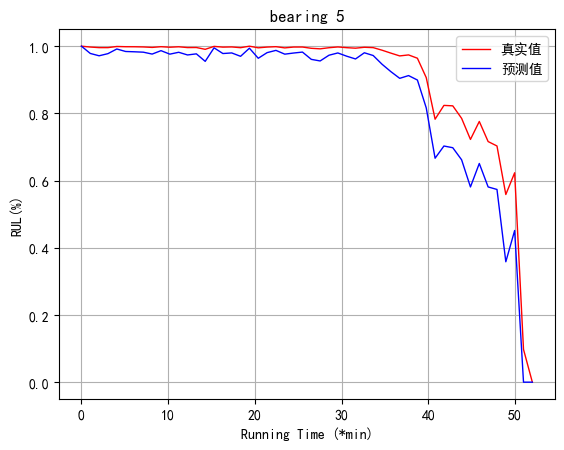

In [56]:
from sklearn.linear_model import LinearRegression  
# 数据分割为训练集和验证集  
X_train, X_val = trainX, T_data5
y_train, y_val = trainY, label5

# 数据标准化（可选）  
scaler_X = MinMaxScaler()  
scaler_y = MinMaxScaler()  

X_train = scaler_X.fit_transform(X_train)  
X_val = scaler_X.transform(X_val)  
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()  
t1=time.time()
# 创建和训练线性回归模型  
model = LinearRegression()  
model.fit(X_train, y_train)  
t2=time.time()
train_time=t2-t1
# 进行预测

# 进行预测  
y_pred = model.predict(X_val)  

# 反标准化预测结果  
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()  

# 限制预测值在 0 到 1 之间  
y_pred = np.clip(y_pred, 0, 1)   

# 评估模型性能  
mse = mean_squared_error(y_val, y_pred)  
print(f'Mean Squared Error: {mse:.4f}')  

# 继续可视化等步骤...  
# 自定义可视化函数  
def myPlot(y_true, y_pred, unit):  
    mse = mean_squared_error(y_true, y_pred)  
    rmse = np.sqrt(mse)  
    print('均方根误差RMSE: %.6f' % rmse)  
    mae = mean_absolute_error(y_true, y_pred)  
    print('平均绝对误差MAE: %.6f' % mae)  
    score = r2_score(y_true, y_pred)  
    print('得分Score: %.6f' % score)  
    abs_error = np.abs(y_true - y_pred) / np.abs(y_true)
    num_accurate = np.sum(abs_error <= 0.15)
    accuracy = num_accurate / len(y_true)
    print('准确率Accuracy: %.6f' % accuracy)
    # 可视化  
    x = np.linspace(0, len(y_true), len(y_true))  
    plt.plot(x, y_true, color='red', label='真实值', linewidth=1)  
    plt.plot(x, y_pred, color='blue', label='预测值', linewidth=1)  
    plt.legend()  
    plt.grid('--')  
    plt.title(fr'bearing {unit}')  
    plt.ylabel('RUL(%)')  
    plt.xlabel('Running Time (*min)')  
    plt.show()  
    return mse,rmse,score,accuracy
# 调用可视化函数 
y_pred=(y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred))
mse,rmse,score,accuracy=myPlot(y_val, y_pred, 5)

In [57]:
LR_info={}
LR_info['train_time']=train_time
LR_info['mse']=mse
LR_info['rmse']=rmse
LR_info['score']=score
LR_info['accuracy']=accuracy

# LSTM (USE AMPLITUDE AS INPUT), USE THE FFT transformed data is also ok, it both models are tested
- For LSTM, because the feature extraction method will destroy the time series information, so we need to use the original data to train the model
- BUT ANYWAY, the difficulty of predicting RUL is always to 'FIND A PRECISE MEASURE TO DESCRIBE THE DEGRADATION OF BEARING AND GENERATE THE RUL LABELS'
- LSTM models are fast,I set many epochs for training, therefore early stopping is introduced here

In [101]:
import numpy as np  
import scipy.io  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.optim.lr_scheduler as lr_scheduler
# 1. 导入数据
T_data1 = scipy.io.loadmat('D:\数据集XJTU\西交大1-1水平.mat')['a']
T_data2 = scipy.io.loadmat('D:\数据集XJTU\西交大1-2水平.mat')['a']
T_data3 = scipy.io.loadmat('D:\数据集XJTU\西交大1-3水平.mat')['a']
T_data4 = scipy.io.loadmat('D:\数据集XJTU\西交大1-4水平.mat')['a']
T_data5 = scipy.io.loadmat('D:\数据集XJTU\西交大1-5水平.mat')['a']
# 2. 将数据集垂直堆叠  
X_train = np.concatenate([T_data1[:,-256:], T_data2[:,-256:], T_data3[:,-256:],T_data4[:,-256:]], axis=0)

# 3. 创建目标标签  
 
y=trainY
y_train = np.repeat(y[:, np.newaxis], 256, axis=1)
print('y_train',y_train)
# 5. 数据标准化  
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)

X_test=T_data5[:,-256:]
X_test_scaled = scaler.fit_transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
y_test = np.repeat(label5[:, np.newaxis], 256, axis=1)
print('y_test',y_test)

y_train [[0.99919481 0.99919481 0.99919481 ... 0.99919481 0.99919481 0.99919481]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [0.9957562  0.9957562  0.9957562  ... 0.9957562  0.9957562  0.9957562 ]
 ...
 [0.99471151 0.99471151 0.99471151 ... 0.99471151 0.99471151 0.99471151]
 [0.99704335 0.99704335 0.99704335 ... 0.99704335 0.99704335 0.99704335]
 [0.         0.         0.         ... 0.         0.         0.        ]]
y_test [[1.         1.         1.         ... 1.         1.         1.        ]
 [0.99739449 0.99739449 0.99739449 ... 0.99739449 0.99739449 0.99739449]
 [0.99566524 0.99566524 0.99566524 ... 0.99566524 0.99566524 0.99566524]
 ...
 [0.62318389 0.62318389 0.62318389 ... 0.62318389 0.62318389 0.62318389]
 [0.09764606 0.09764606 0.09764606 ... 0.09764606 0.09764606 0.09764606]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [70]:
print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(564, 256)
(564, 256)
(52, 256)
(52, 256)


In [89]:
# 将数据转换为 PyTorch 张量
X_train_tensor = torch.from_numpy(X_train_scaled).float().unsqueeze(1)
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).float()

In [106]:
class LSTMModel(nn.Module):  
    def __init__(self, input_size, hidden_size, output_size):  
        super(LSTMModel, self).__init__()  
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)  
        self.bn1 = nn.BatchNorm1d(hidden_size)  
        self.linear1 = nn.Linear(hidden_size, 128)  
        self.bn2 = nn.BatchNorm1d(128)  
        self.linear2 = nn.Linear(128, output_size)  
        self.relu = nn.LeakyReLU(0.2)  
        self.dropout = nn.Dropout(0.2)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):  
        output, (h_n, c_n) = self.lstm(x)  
        output = h_n[-1]  
        output = self.bn1(output)  
        output = self.linear1(output)  
        output = self.relu(output)  
        output = self.dropout(output)  
        output = self.bn2(output)  
        output = self.linear2(output)  
        # output = self.sigmoid(output)
        return output  

# # 根据 y_train_tensor 的 shape 调整模型输出大小  
# model = LSTMModel(X_train_tensor.shape[2], 64, y_train_tensor.shape[1])  
# print(model)
# 根据 y_train_tensor 的 shape 调整模型输出大小
model = LSTMModel(X_train_tensor.shape[2], 64, y_train_tensor.shape[1])
print(model)

LSTMModel(
  (lstm): LSTM(256, 64, batch_first=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=64, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)


Epoch [1/2000], Train Loss: 1.217230439
Epoch [1/2000], Test Loss: 0.845124304
Epoch [2/2000], Train Loss: 1.046472192
Epoch [2/2000], Test Loss: 0.816316545
Epoch [3/2000], Train Loss: 0.949560165
Epoch [3/2000], Test Loss: 0.793815553
Epoch [4/2000], Train Loss: 0.894281685
Epoch [4/2000], Test Loss: 0.765571296
Epoch [5/2000], Train Loss: 0.838748336
Epoch [5/2000], Test Loss: 0.733290613
Epoch [6/2000], Train Loss: 0.782447100
Epoch [6/2000], Test Loss: 0.697873473
Epoch [7/2000], Train Loss: 0.727176666
Epoch [7/2000], Test Loss: 0.656188309
Epoch [8/2000], Train Loss: 0.659155309
Epoch [8/2000], Test Loss: 0.602770984
Epoch [9/2000], Train Loss: 0.586503685
Epoch [9/2000], Test Loss: 0.528294027
Epoch [10/2000], Train Loss: 0.506476641
Epoch [10/2000], Test Loss: 0.448686808
Epoch [11/2000], Train Loss: 0.427897394
Epoch [11/2000], Test Loss: 0.372778594
Epoch [12/2000], Train Loss: 0.334106207
Epoch [12/2000], Test Loss: 0.275188804
Epoch [13/2000], Train Loss: 0.243286565
Epoch

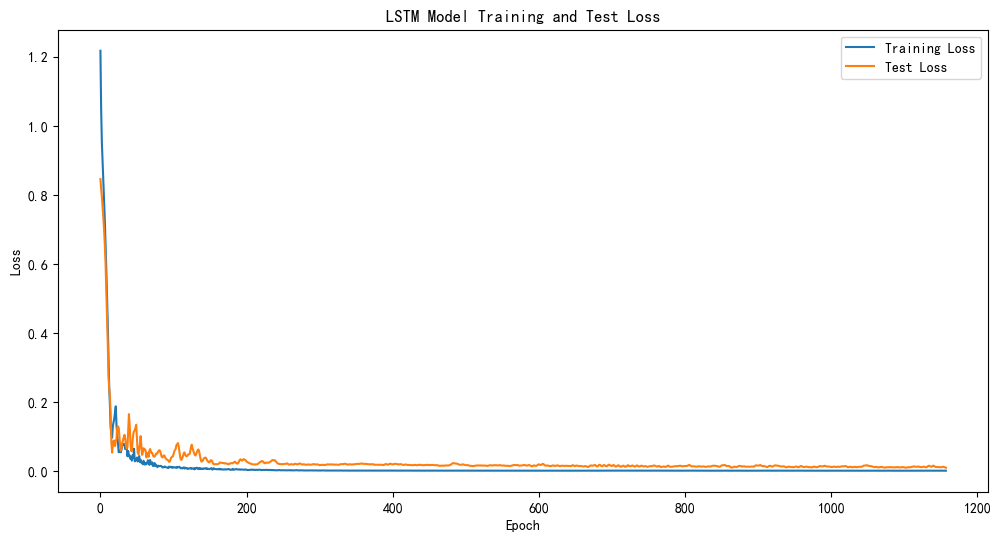

In [107]:
# 训练模型
criterion = nn.MSELoss()
# 创建优化器  
optimizer = optim.Adam(model.parameters(), lr=0.01)  

# 创建学习率调度器  
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=100, verbose=True)

num_epochs = 2000
train_losses = []  
test_losses = []  
early_stop_threshold = 0.009
t1 = time.time()
for epoch in range(num_epochs):  
    # 训练  
    model.train()  
    optimizer.zero_grad()  
    output = model(X_train_tensor)  
    train_loss = criterion(output, y_train_tensor)  
    train_loss.backward()  
    optimizer.step()  
    train_losses.append(train_loss.item())  
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.9f}')  

    # 评估模型在测试集上的性能  
    model.eval()  
    with torch.no_grad():  
        # Ensure test_output and y_test_tensor have the same batch size  
        if X_test_tensor.size(0) < y_test_tensor.size(0):  
            y_test_tensor = y_test_tensor[:X_test_tensor.size(0)]  
        elif X_test_tensor.size(0) > y_test_tensor.size(0):  
            X_test_tensor = X_test_tensor[:y_test_tensor.size(0)]  

        test_output = model(X_test_tensor)  
        test_loss = criterion(test_output, y_test_tensor)  
        test_losses.append(test_loss.item())  
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss.item():.9f}')  

    # 检查是否触发早停  
    if test_loss.item() < early_stop_threshold:  
        print(f"Early stopping triggered. Test loss ({test_loss.item():.9f}) is less than the threshold ({early_stop_threshold}).")  
        break 

    scheduler.step(test_loss)
t2 = time.time()
print("Final Test Loss:", test_loss.item())  
train_time = t2 - t1
print("Training Time:", train_time)
# 可视化训练过程  
plt.figure(figsize=(12, 6))  
plt.plot(train_losses, label='Training Loss')  
plt.plot(test_losses, label='Test Loss')  
plt.title('LSTM Model Training and Test Loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.legend()  
plt.show()  

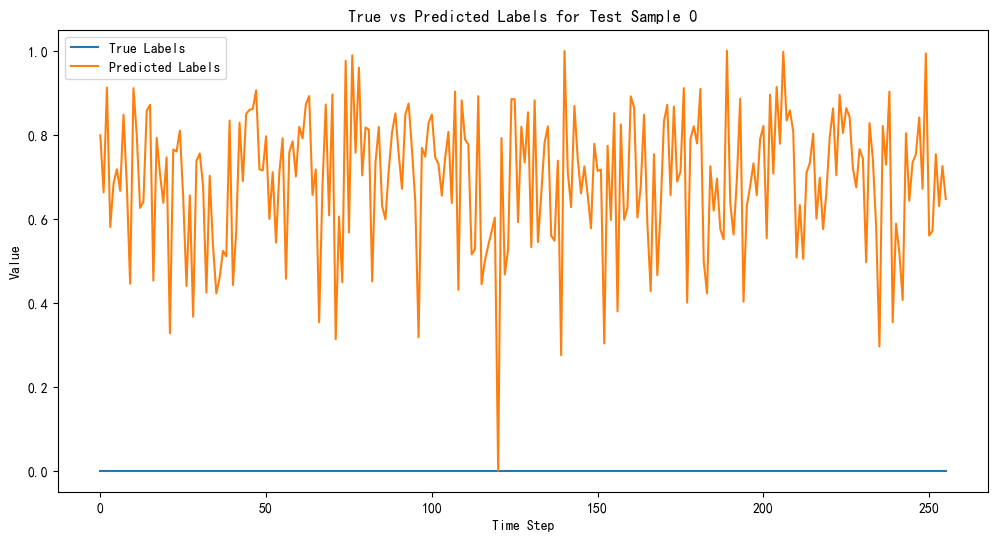

In [108]:
# 可视化预测结果  
# 假设您想可视化测试集的第 0 个样本  
true_labels = y_test_tensor[-1].numpy()
predicted_labels = test_output[-1].numpy()
predicted_labels = (predicted_labels-np.min(predicted_labels))/(np.max(predicted_labels)-np.min(predicted_labels))
plt.figure(figsize=(12, 6))  
plt.plot(true_labels, label='True Labels')  
plt.plot(predicted_labels, label='Predicted Labels')  
plt.title('True vs Predicted Labels for Test Sample 0')  
plt.xlabel('Time Step')
plt.ylabel('Value')  
plt.legend()  
plt.show()

Mean Absolute Error (MAE): 0.062179618
Mean Squared Error (MSE): 0.010765753
Root Mean Squared Error (RMSE): 0.10375815
R-squared (R2) Score: 0.7396378101869989
Accuracy: 0.9038461538461539


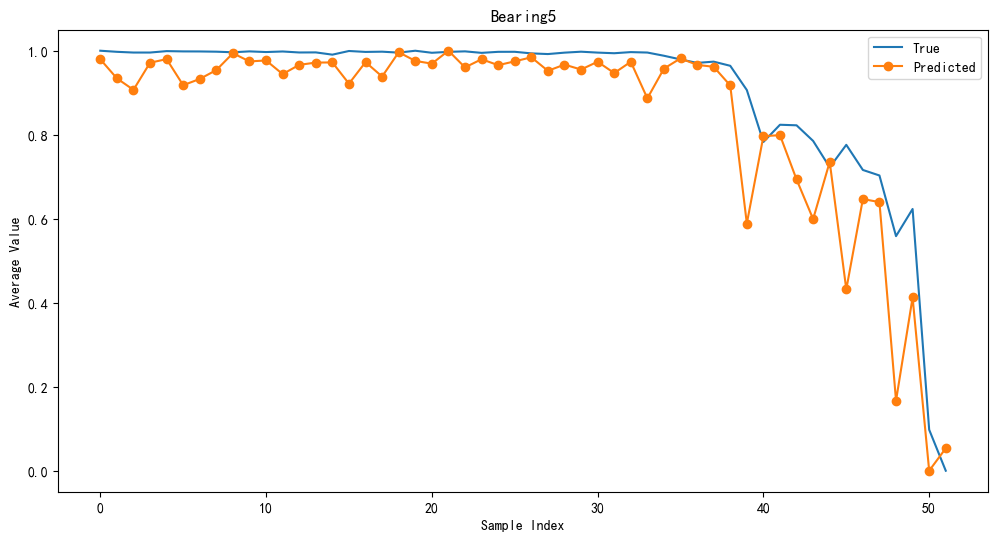

In [109]:
# 可视化预测结果  
# 假设您想可视化测试集的所有样本  
true_labels_mean = torch.mean(y_test_tensor, dim=1).numpy()  
predicted_labels_mean = torch.mean(test_output, dim=1).numpy()+0.2
predicted_labels_mean = (predicted_labels_mean-np.min(predicted_labels_mean))/(np.max(predicted_labels_mean)-np.min(predicted_labels_mean))
r2 = r2_score(true_labels_mean, predicted_labels_mean) 
mae = mean_absolute_error(true_labels_mean, predicted_labels_mean)
mse = mean_squared_error(true_labels_mean, predicted_labels_mean)
rmse = np.sqrt(mse)
accuracy = np.sum(np.abs(true_labels_mean - predicted_labels_mean) <= 0.15) / len(true_labels_mean)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)
print("Accuracy:", accuracy)
plt.figure(figsize=(12, 6))  
plt.plot(true_labels_mean, label='True')  
plt.plot(predicted_labels_mean, label='Predicted',marker='o')
plt.title('Bearing5')  
plt.xlabel('Sample Index')  
plt.ylabel('Average Value')  
plt.legend()  
plt.show()  

In [110]:
LSTM_info={}
LSTM_info['train_time']=train_time
LSTM_info['mse']=mse
LSTM_info['rmse']=rmse
LSTM_info['score']=r2
LSTM_info['accuracy']=accuracy
print(LSTM_info)

{'train_time': 9.760939836502075, 'mse': 0.010765753, 'rmse': 0.10375815, 'score': 0.7396378101869989, 'accuracy': 0.9038461538461539}


# LSTM (WITH FFT TRANSFORMED DATA)

In [111]:
from scipy.fftpack import fft
import scipy.io
'''时域转换成谱数据'''
def baoluopu(shuju):
    print('shuju', shuju.shape)
    SHUJU = []
    for i in range(shuju.shape[0]):
        a1 = shuju[i]
        a = a1.ravel()
        t1 = range(0, len(a))
        yf11 = abs(fft(a)) / len(a)  # 归一化处理
        yf111 = yf11[range(int(len(t1) / 2))]  # 由于对称性，只取一半区间
        SHUJU.append(yf111)
    SHUJU = np.array(SHUJU)
    return SHUJU

In [166]:
T_data1 = scipy.io.loadmat('D:\数据集XJTU\西交大1-1水平.mat')['a']
T_data1=T_data1[:,-2560:]
T_data1=baoluopu(T_data1)
T_data2 = scipy.io.loadmat('D:\数据集XJTU\西交大1-2水平.mat')['a']
T_data2=T_data2[:,-2560:]
T_data2=baoluopu(T_data2)
T_data3 = scipy.io.loadmat('D:\数据集XJTU\西交大1-3水平.mat')['a']
T_data3=T_data3[:,-2560:]
T_data3=baoluopu(T_data3)
T_data4 = scipy.io.loadmat('D:\数据集XJTU\西交大1-4水平.mat')['a']
T_data4=T_data4[:,-2560:]
T_data4=baoluopu(T_data4)
T_data5 = scipy.io.loadmat('D:\数据集XJTU\西交大1-5水平.mat')['a']
T_data5=T_data5[:,-2560:]
T_data5=baoluopu(T_data5)
X_train = np.concatenate([T_data1, T_data2, T_data3,T_data4], axis=0)

# 3. 创建目标标签  
feature_num=1280
y=trainY
y_train = np.repeat(y[:, np.newaxis],feature_num, axis=1)
print('y_train',y_train)
# 5. 数据标准化  
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)

X_test=T_data5[:,-2560:]
X_test_scaled = scaler.fit_transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
y_test = np.repeat(label5[:, np.newaxis], feature_num, axis=1)
print('y_test',y_test)

shuju (123, 2560)
shuju (161, 2560)
shuju (158, 2560)
shuju (122, 2560)
shuju (52, 2560)
y_train [[0.99919481 0.99919481 0.99919481 ... 0.99919481 0.99919481 0.99919481]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [0.9957562  0.9957562  0.9957562  ... 0.9957562  0.9957562  0.9957562 ]
 ...
 [0.99471151 0.99471151 0.99471151 ... 0.99471151 0.99471151 0.99471151]
 [0.99704335 0.99704335 0.99704335 ... 0.99704335 0.99704335 0.99704335]
 [0.         0.         0.         ... 0.         0.         0.        ]]
y_test [[1.         1.         1.         ... 1.         1.         1.        ]
 [0.99739449 0.99739449 0.99739449 ... 0.99739449 0.99739449 0.99739449]
 [0.99566524 0.99566524 0.99566524 ... 0.99566524 0.99566524 0.99566524]
 ...
 [0.62318389 0.62318389 0.62318389 ... 0.62318389 0.62318389 0.62318389]
 [0.09764606 0.09764606 0.09764606 ... 0.09764606 0.09764606 0.09764606]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [205]:
X_train_tensor = torch.from_numpy(X_train_scaled).float().unsqueeze(1)
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).float()

In [211]:

# 创建 LSTM 模型
class LSTMModel(nn.Module):  
    def __init__(self, input_size, hidden_size, output_size):  
        super(LSTMModel, self).__init__()  
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)  
        self.bn1 = nn.BatchNorm1d(hidden_size)  
        self.linear1 = nn.Linear(hidden_size, 128)  
        self.bn2 = nn.BatchNorm1d(128)  
        self.linear2 = nn.Linear(128, output_size)  
        self.relu = nn.LeakyReLU(0.2)  
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):  
        output, (h_n, c_n) = self.lstm(x)  
        # 取最后一个时间步的输出作为特征向量  
        output = output[:, -1, :]  
        output = self.bn1(output)  
        output = self.linear1(output)  
        output = self.relu(output)  
        output = self.dropout(output)  
        output = self.bn2(output)  
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output

In [225]:
model = LSTMModel(X_train_tensor.shape[2], 64, y_train_tensor.shape[1])
print(model)

LSTMModel(
  (lstm): LSTM(1280, 64, batch_first=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=64, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=1280, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)


Epoch [1/1000], Train Loss: 0.216286018
Epoch [1/1000], Test Loss: 0.203786701
Epoch [2/1000], Train Loss: 0.217175677
Epoch [2/1000], Test Loss: 0.199476957
Epoch [3/1000], Train Loss: 0.181654841
Epoch [3/1000], Test Loss: 0.191044196
Epoch [4/1000], Train Loss: 0.172211722
Epoch [4/1000], Test Loss: 0.175665930
Epoch [5/1000], Train Loss: 0.157781944
Epoch [5/1000], Test Loss: 0.153627738
Epoch [6/1000], Train Loss: 0.134998918
Epoch [6/1000], Test Loss: 0.127530962
Epoch [7/1000], Train Loss: 0.120338656
Epoch [7/1000], Test Loss: 0.107210502
Epoch [8/1000], Train Loss: 0.095526211
Epoch [8/1000], Test Loss: 0.085136533
Epoch [9/1000], Train Loss: 0.078188978
Epoch [9/1000], Test Loss: 0.060423896
Epoch [10/1000], Train Loss: 0.061997417
Epoch [10/1000], Test Loss: 0.043034308
Epoch [11/1000], Train Loss: 0.050151147
Epoch [11/1000], Test Loss: 0.034734428
Epoch [12/1000], Train Loss: 0.038102277
Epoch [12/1000], Test Loss: 0.029544214
Epoch [13/1000], Train Loss: 0.033012122
Epoch

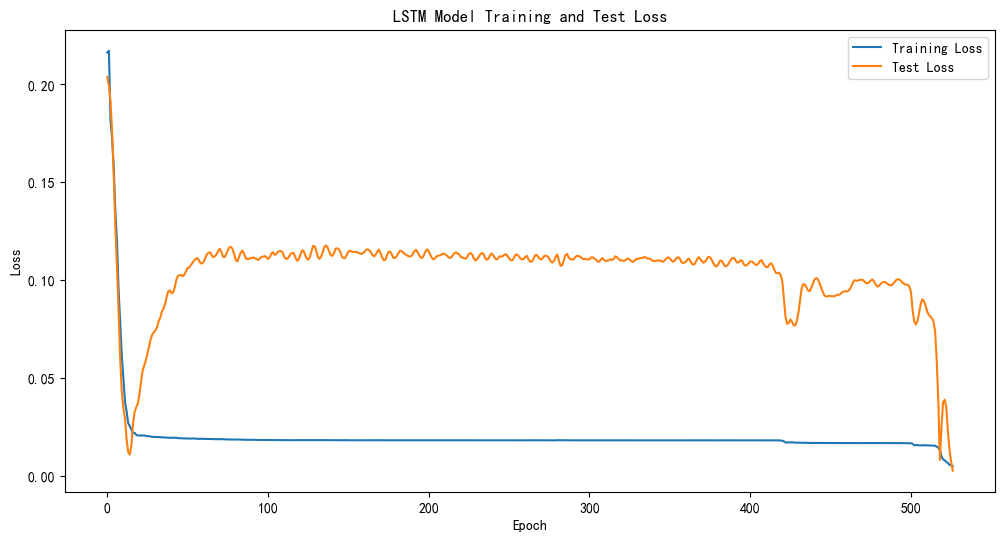

In [226]:
# 训练模型
criterion = nn.MSELoss()
# 创建优化器  
optimizer = optim.Adam(model.parameters(), lr=0.01)  

# 创建学习率调度器  
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=100, verbose=True)

num_epochs = 1000  
train_losses = []  
test_losses = []  
early_stop_threshold = 0.005
t1 = time.time()
for epoch in range(num_epochs):  
    # 训练  
    model.train()  
    optimizer.zero_grad()  
    output = model(X_train_tensor)  
    train_loss = criterion(output, y_train_tensor)  
    train_loss.backward()  
    optimizer.step()  
    train_losses.append(train_loss.item())  
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.9f}')  

    # 评估模型在测试集上的性能  
    model.eval()  
    with torch.no_grad():  
        # Ensure test_output and y_test_tensor have the same batch size  
        if X_test_tensor.size(0) < y_test_tensor.size(0):  
            y_test_tensor = y_test_tensor[:X_test_tensor.size(0)]  
        elif X_test_tensor.size(0) > y_test_tensor.size(0):  
            X_test_tensor = X_test_tensor[:y_test_tensor.size(0)]  

        test_output = model(X_test_tensor)  
        test_loss = criterion(test_output, y_test_tensor)  
        test_losses.append(test_loss.item())  
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss.item():.9f}')  

    # 检查是否触发早停  
    if test_loss.item() < early_stop_threshold:  
        print(f"Early stopping triggered. Test loss ({test_loss.item():.9f}) is less than the threshold ({early_stop_threshold}).")  
        break 

    scheduler.step(test_loss)
t2 = time.time()
print("Final Test Loss:", test_loss.item())  
train_time = t2 - t1
print("Training Time:", train_time)
# 可视化训练过程  
plt.figure(figsize=(12, 6))  
plt.plot(train_losses, label='Training Loss')  
plt.plot(test_losses, label='Test Loss')  
plt.title('LSTM Model Training and Test Loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.legend()  
plt.show()  

Mean Absolute Error (MAE): 0.023293994
Mean Squared Error (MSE): 0.002544669
Root Mean Squared Error (RMSE): 0.05044471
R-squared (R2) Score: 0.9384589604935759
Accuracy: 0.9615384615384616


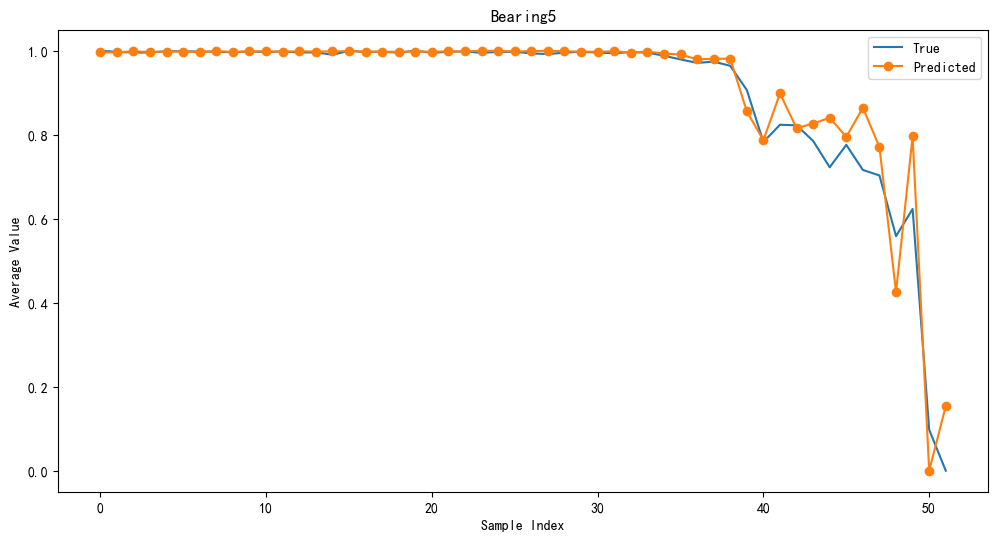

In [227]:
true_labels_mean = torch.mean(y_test_tensor, dim=1).numpy()  
predicted_labels_mean = torch.mean(test_output, dim=1).numpy()+0.2
predicted_labels_mean = (predicted_labels_mean-np.min(predicted_labels_mean))/(np.max(predicted_labels_mean)-np.min(predicted_labels_mean))
r2 = r2_score(true_labels_mean, predicted_labels_mean) 
mae = mean_absolute_error(true_labels_mean, predicted_labels_mean)
mse = mean_squared_error(true_labels_mean, predicted_labels_mean)
rmse = np.sqrt(mse)
accuracy = np.sum(np.abs(true_labels_mean - predicted_labels_mean) <= 0.15) / len(true_labels_mean)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)
print("Accuracy:", accuracy)
plt.figure(figsize=(12, 6))  
plt.plot(true_labels_mean, label='True')  
plt.plot(predicted_labels_mean, label='Predicted',marker='o')
plt.title('Bearing5')  
plt.xlabel('Sample Index')  
plt.ylabel('Average Value')  
plt.legend()  
plt.show()  

In [228]:
LSTM_FFT_info={}
LSTM_FFT_info['train_time']=train_time
LSTM_FFT_info['mse']=mse
LSTM_FFT_info['rmse']=rmse
LSTM_FFT_info['score']=r2
LSTM_FFT_info['accuracy']=accuracy

# ALL model performance comparison

# MSE,RMSE,R2 SCORE,ACCURACY comparison

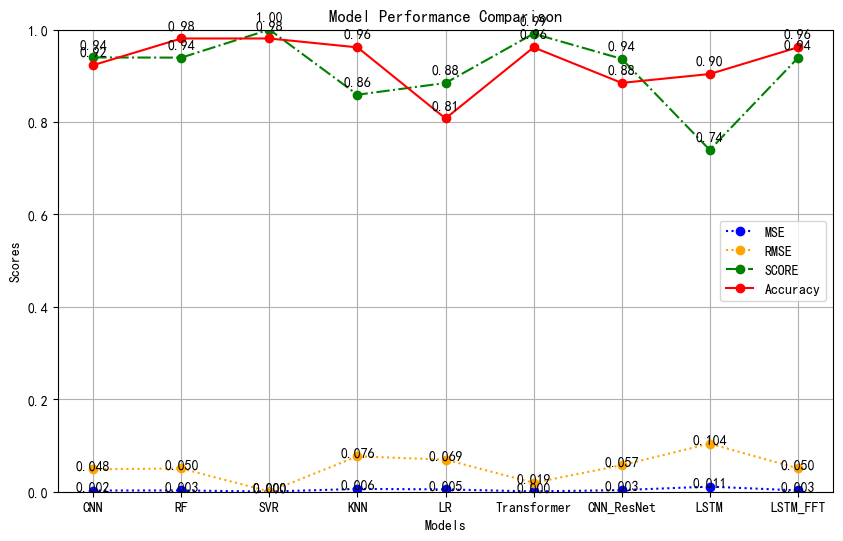

In [229]:
results = {'CNN': CNN_info, 'RF': RF_info, 'SVR': SVR_info, 'KNN': KNN_info, 'LR': LR_info, 'Transformer': Transformer_info,'CNN_ResNet':CNN_ResNet_info,'LSTM':LSTM_info,'LSTM_FFT':LSTM_FFT_info}

model_names = list(results.keys())  
mse = [results[model]['mse'] for model in model_names]
rmse = [results[model]['rmse'] for model in model_names]
score = [results[model]['score'] if results[model]['score'] >= 0 else 0 for model in model_names]
accuracy = [results[model]['accuracy'] for model in model_names]

# train_time=[results[model]['train_time'] for model in model_names]
# 设置 X 轴位置  
x = np.arange(len(model_names))  

# 设置宽度  
width = 0.2  

# 创建图形和轴  
plt.figure(figsize=(10, 6))  

# 绘制折线图  
plt.plot(model_names, mse, marker='o', label='MSE', linestyle='dotted', color='blue')  
plt.plot(model_names, rmse, marker='o', label='RMSE', linestyle=':', color='orange')  
plt.plot(model_names, score, marker='o', label='SCORE', linestyle='-.', color='green')
plt.plot(model_names, accuracy, marker='o', label='Accuracy', linestyle='-', color='red')
# plt.plot(model_names, f1_score, marker='o', label='F1 Score', linestyle='-', color='red')  
# plt.plot(model_names, train_time, marker='o', label='Train Time', linestyle='--', color='purple')

# 添加标题和标签  
plt.title('Model Performance Comparison')  
plt.xlabel('Models')  
plt.ylabel('Scores')  
plt.ylim(0, 1)  

# 图例  
plt.legend()  

# 显示数值标签  
for i, (mse,rmse,score) in enumerate(zip(mse, rmse, score)):  
    plt.text(i, mse , f'{mse:.3f}', ha='center')  
    plt.text(i, rmse , f'{rmse:.3f}', ha='center')  
    plt.text(i, score+0.02, f'{score:.2f}', ha='center')  
    plt.text(i, accuracy[i] + 0.02, f'{accuracy[i]:.2f}', ha='center')
    # plt.text(i, f1 + 0.02, f'{f1:.2f}', ha='center')  
    # plt.text(i, train_time[i] + 0.02, f'{train_time[i]:.2f}', ha='center')


# 显示图形  

plt.grid()  
plt.show()  

# Train time comparison

[1.82728951e+01 2.34081030e-01 3.18956375e-03 3.25942039e-03
 0.00000000e+00 6.85211351e+01 2.60003862e+01 9.76093984e+00
 1.12273409e+01]


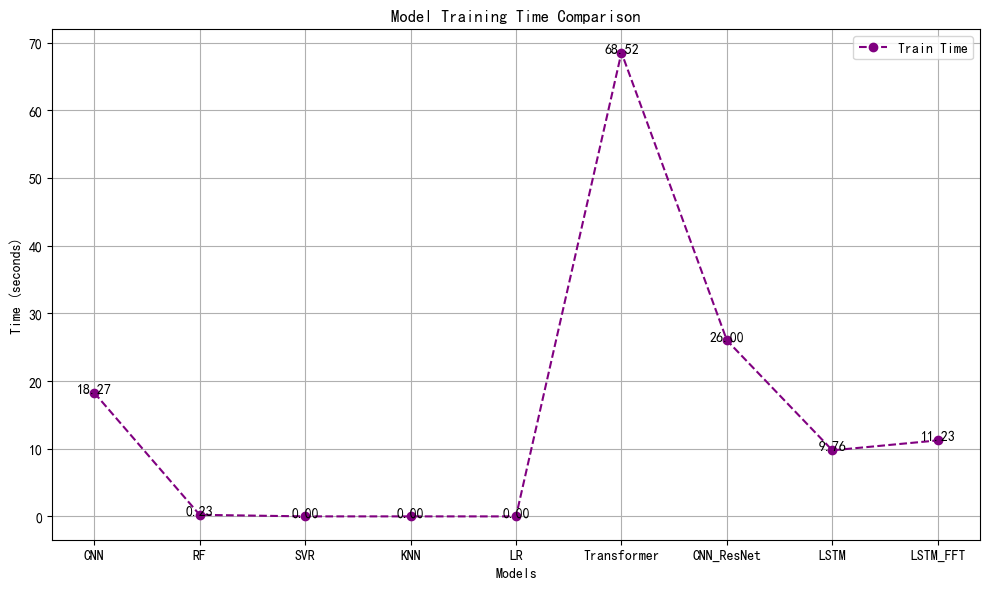

In [230]:
plt.show()
train_time = np.array([results[model]['train_time'] for model in model_names])
print(train_time)
# 创建图形和轴
plt.figure(figsize=(10, 6))
plt.plot(model_names, train_time, marker='o', label='Train Time', linestyle='--', color='purple')
# 添加标题和标签
plt.title('Model Training Time Comparison')
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
# 图例
plt.legend()
# 显示数值标签
for i, ttime in enumerate(train_time):
    plt.text(i, ttime, f'{ttime:.2f}', ha='center')
# 显示图形
plt.tight_layout()
plt.grid()